In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from loader import *
import h5py
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle
import io

from datetime import datetime

from ANN_regression import *
from torchdiffeq import odeint
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import FancyArrowPatch, Ellipse
import matplotlib.lines as mlines

from matplotlib.legend_handler import HandlerBase
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FixedLocator, NullFormatter

<h2> Figures 10-13: A posteriori simulations on different mixture fractions

Compare the PV of optimized with the optimized PV for different test trajectories.

Use the ANN closure model to construct a model that computes the PV source term given f-PV.</br> And another one to reconstruct the full state space given f-PV.

<h3> Prepare all the datasets

In [3]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/"
path_data = "data-files/"
regression_modelname = "Xu_2026-01-20_14h18_s7"   #handles negative values with abs, 300k epo without minibatching
regression_modelname_optimized = "Optimized_Tr0D-2s_s2_2026-01-20_16h11_s7" #handles negative values with abs, 300k epo without minibatching

regression_full_modelname = "Xu_full_2026-01-26_15h29" #With rectangular manifold
regression_full_modelname_optimized = "Optimized_full_Tr0D-2s_s2_2026-01-26_16h02" #rectangular manifold now

path_regression_model = "paper/models/"

## Define the global datasets

In [4]:
#create all the datasets
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)

---
<h3> Heuristic PV: PV source term model - f-PV to PV source

In [5]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        return super().find_class(module, name)

with open(f'{path_regression_model}{regression_modelname}_metadata.pkl', 'rb') as f:
    loaded_dict = CPU_Unpickler(f).load()
    
model_params = loaded_dict["model_params"]

mins_input_Xu = loaded_dict["mins_input"]
maxs_input_Xu = loaded_dict["maxs_input"]
mins_output_Xu = loaded_dict["mins_output"]
maxs_output_Xu = loaded_dict["maxs_output"]

PV_Xu_source_min_train = loaded_dict["PV_Xu_source_min_train"]
log_PVsource = loaded_dict["log_PVsource"]
epsilon = loaded_dict["epsilon"]
Xu_H2O = loaded_dict["Xu_H2O"] #"Xu"
log_transform = loaded_dict["log transformation"]
scaledManifold_Xu = loaded_dict["scaled manifold"]

model_regression_Xu = ANN_regression(**model_params)
model_regression_Xu.load_state_dict(torch.load(f"{path_regression_model}{regression_modelname}_model.pth", weights_only=False, map_location=torch.device('cpu')))

def inverse_symlog(x_prime, threshold):
    return np.sign(x_prime) * threshold * (10 ** np.abs(x_prime) - 1)

C:\Windows\Temp\ipykernel_16556\359117153.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu')


In [6]:
prediction_test_trajectories = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

        if(scaledManifold_Xu):
            PV_Xu_test = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())
            #print(PV_Xu_test)

        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
        f_PV_Xu_test_torch = torch.tensor(f_PV_Xu_test)
        f_PV_Xu_test_torch_scaled = (f_PV_Xu_test_torch - mins_input_Xu)/(maxs_input_Xu - mins_input_Xu) - 0.5
    
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_source_test = test_trajectory_source["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()
    
    
    PV_Xu_source_test_predicted = model_regression_Xu(f_PV_Xu_test_torch_scaled)
    PV_Xu_source_test_predicted = (PV_Xu_source_test_predicted+1) /2 * (maxs_output_Xu - mins_output_Xu) + mins_output_Xu
    PV_Xu_source_test_predicted = PV_Xu_source_test_predicted.detach().numpy()
    if(log_PVsource):
        if(log_transform == "continuous-symlog"):
            PV_Xu_source_test_predicted = inverse_symlog(PV_Xu_source_test_predicted, epsilon)
        elif(log_transform == "log"):
            PV_Xu_source_test_predicted = 10**PV_Xu_source_test_predicted
    
    prediction_test_trajectories.append(PV_Xu_source_test_predicted)

    MSE_Xu_test = mean_squared_error(PV_Xu_source_test, PV_Xu_source_test_predicted)

    print(f"MSE of Xu for test trajectory {i}: {MSE_Xu_test}")
    

MSE of Xu for test trajectory 0: 5306586.295000174
MSE of Xu for test trajectory 1: 1872633.2848183797
MSE of Xu for test trajectory 2: 1601270.4551591042
MSE of Xu for test trajectory 3: 3607710.3756123534
MSE of Xu for test trajectory 4: 7028487.068438524
MSE of Xu for test trajectory 5: 10558955.23437965
MSE of Xu for test trajectory 6: 11937904.347299866
MSE of Xu for test trajectory 7: 10568721.147007642
MSE of Xu for test trajectory 8: 9927661.818661742
MSE of Xu for test trajectory 9: 15271497.403741347


C:\Windows\Temp\ipykernel_16556\2406822639.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


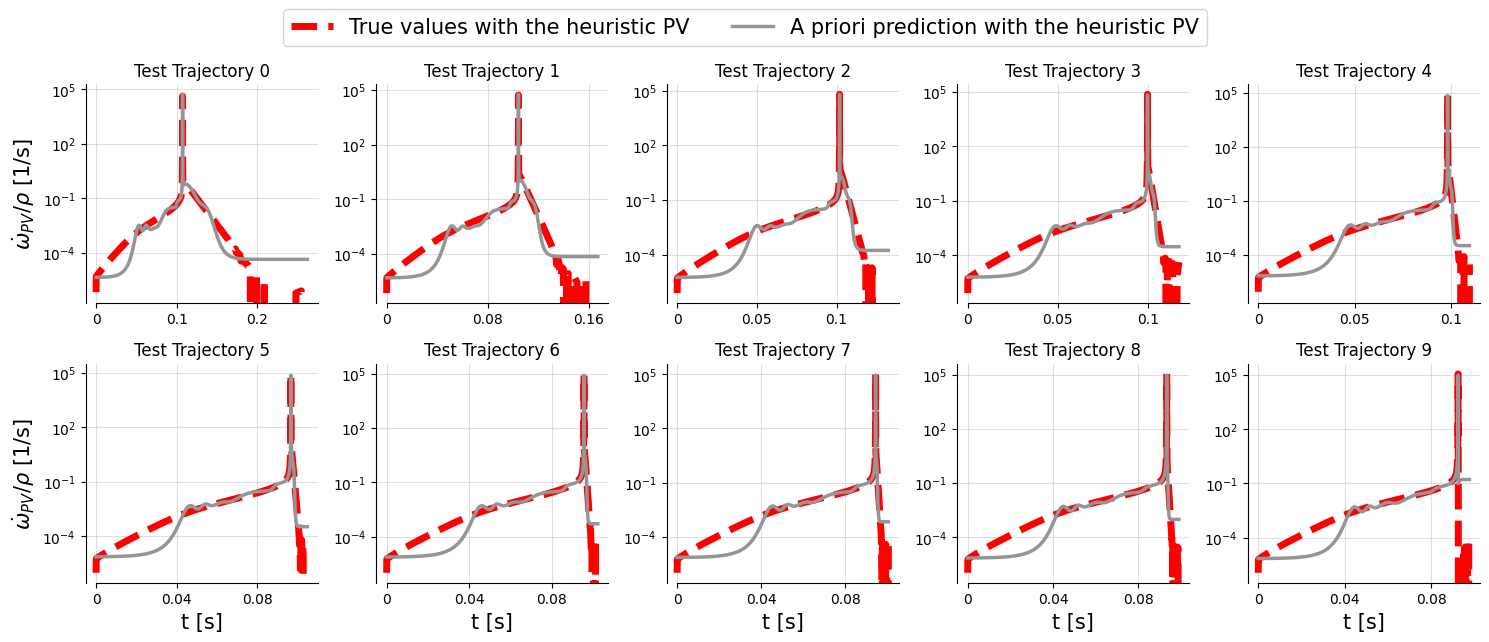

In [25]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"
name = f"Apriori_ANN_{regression_modelname}.png"
namePdf = f"Apriori_ANN_{regression_modelname}.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

greys = cm.get_cmap('Greys')

def zero_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        return f"{x:g}"

for i in range(num_test_trajectories):  
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    ax = axes[i]
    ax.plot(test_trajectory_time, PV_Xu_source_test, label="True values with the heuristic PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories[i], label="A priori prediction with the heuristic PV", color = greys(0.5), linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

    ax.xaxis.set_major_formatter(FuncFormatter(zero_formatter))
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

---
<h3> Heuristic PV: Evolve the PV over time

In [31]:
class ODEXu(torch.nn.Module):

    def __init__(self, min_max_PV):
        super().__init__()
        self.outputs = [] #list to store the predicted source terms
        self.min_PV = min_max_PV[0]
        self.max_PV = min_max_PV[1]

    def forward(self, t, y):
        
        y_scaled = y.clone() #avoid in place changes
        if scaledManifold_Xu:
            y_scaled[0, 1] = (y_scaled[0, 1] - self.min_PV)/(self.max_PV - self.min_PV)

        f_PV = (y_scaled-mins_input_Xu) / (maxs_input_Xu - mins_input_Xu) - 0.5
        PV_source_predicted = model_regression_Xu(f_PV)
        PV_source_predicted = (PV_source_predicted+1) /2 * (maxs_output_Xu - mins_output_Xu) + mins_output_Xu

        if(log_transform == "continuous-symlog"):
            PV_source_predicted = inverse_symlog(PV_source_predicted, epsilon)
        elif(log_transform == "log"):
            PV_source_predicted = 10**PV_source_predicted

        
        self.outputs.append(PV_source_predicted.detach().numpy())

        zero = torch.tensor([[0.0]], dtype=PV_source_predicted.dtype, device=PV_source_predicted.device)
        f_PV_source_predicted = torch.cat((zero, PV_source_predicted), dim=1) #add a zero for the mixture fraction

        return f_PV_source_predicted

In [32]:
idx_start_simulation = 0
list_simulations_Xu = []
list_predicted_PV_source = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Date:", date_str)
print("Hour:", time_str)

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_Xu_test[idx_start_simulation,:]
    initial_condition = torch.tensor(initial_condition).unsqueeze(0)

    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    
    ODEXu_instance = ODEXu([PV_Xu_test.min(), PV_Xu_test.max()])
    numerical_solution_Xu = odeint(ODEXu_instance, initial_condition, t_coordinates) #, method="rk4")
    numerical_solution_Xu = numerical_solution_Xu.squeeze(1)
    list_simulations_Xu.append(numerical_solution_Xu)
    list_predicted_PV_source.append(ODEXu_instance.outputs)

    MSE_Xu_test_simulation = mean_squared_error(PV_Xu_test[idx_start_simulation:], numerical_solution_Xu[:,1].detach().numpy())

    print(f"MSE for test trajectory {i}: {MSE_Xu_test_simulation}")

Date: 2026-02-19
Hour: 21h12
MSE for test trajectory 0: 0.046128455196301724
MSE for test trajectory 1: 0.055497755986602185
MSE for test trajectory 2: 0.0645933718511446
MSE for test trajectory 3: 0.0736491081251268
MSE for test trajectory 4: 0.08232159658088957
MSE for test trajectory 5: 0.09026177037445111
MSE for test trajectory 6: 0.0972927635781538
MSE for test trajectory 7: 0.10331077642432253
MSE for test trajectory 8: 0.10840295543023701
MSE for test trajectory 9: 0.11279444711455372


Use the MSE to quantitatively assess the quality of the simulationsn take the average MSE?

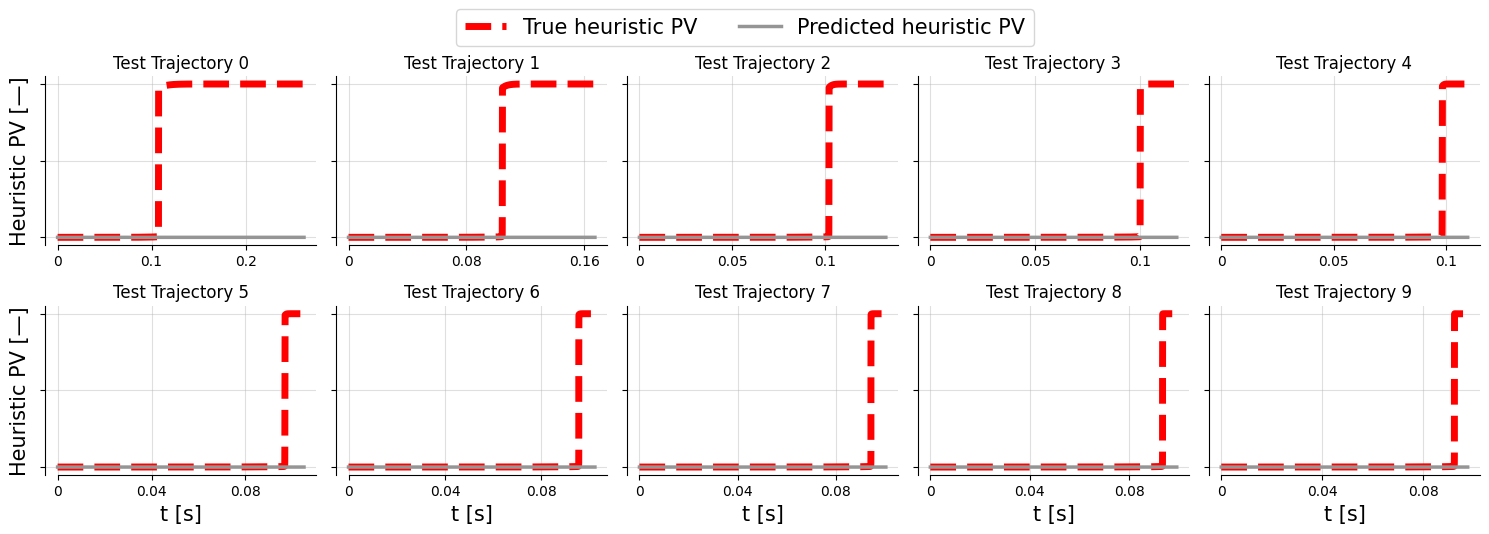

In [33]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"

idx_start_simulation = 0

num_test_trajectories = 10
rows, cols = 2, 5 # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

def zero_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        return f"{x:g}"

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        #PV_Xu_test = (PV_Xu_test - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_Xu_test_min = PV_Xu_test.min()
    PV_Xu_test_max = PV_Xu_test.max()

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()

        min_perc = 0.003
        max_perc = 0.995
        
        max_val = H2O_array.max()
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], (PV_Xu_test[idx_1:idx_99] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
        ax.plot(test_trajectory_time[idx_1:idx_99], (list_simulations_Xu[i][idx_1:idx_99,1] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="Predicted heuristic PV", color = greys(0.5), linewidth = 2.5)

    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_Xu_test[idx_start_simulation:] - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_Xu[i][:,1].detach().numpy() - PV_Xu_test_min)/(PV_Xu_test_max - PV_Xu_test_min), label="Predicted heuristic PV", color = greys(0.5), linewidth = 2.5)
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])
    ax.grid(True, linestyle='-', alpha=0.4)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

    ax.xaxis.set_major_formatter(FuncFormatter(zero_formatter))
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Heuristic PV [\u2014]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

<h3> Run the a posteriori simulation longer

In [14]:
list_simulations_Xu_ext = []
list_predicted_PV_source_ext = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Date:", date_str)
print("Hour:", time_str)

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_Xu_test[0,:]
    initial_condition = torch.tensor(initial_condition).unsqueeze(0)

    t_coordinates = test_trajectory_time[0:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    deltaTime = t_coordinates[-1] - t_coordinates[-2]

    last_value = t_coordinates[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        t_coordinates = torch.cat((t_coordinates, extension))
    
    ODEXu_instance = ODEXu([PV_Xu_test.min(), PV_Xu_test.max()])
    numerical_solution_Xu = odeint(ODEXu_instance, initial_condition, t_coordinates) #, method="rk4")
    numerical_solution_Xu = numerical_solution_Xu.squeeze(1)
    list_simulations_Xu_ext.append(numerical_solution_Xu)
    list_predicted_PV_source_ext.append(ODEXu_instance.outputs)

Date: 2026-02-19
Hour: 21h06


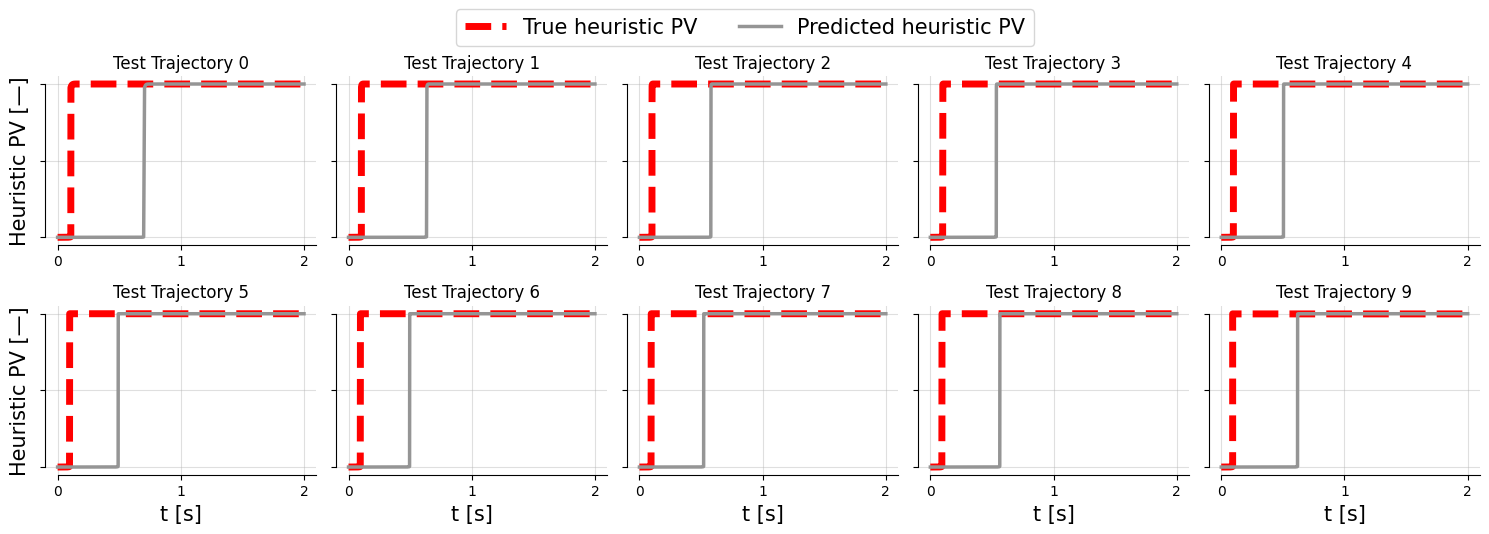

In [48]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"
name = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.png"
namePdf = f"Heuristic vs optimized - A posteriori - Heuristic PV - ANN {regression_modelname}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_Xu_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_Xu_test_ext = np.vstack((PV_Xu_test, extension)) #concatenate the extension with the original value

    min_PV = PV_Xu_test_ext.min()
    max_PV = PV_Xu_test_ext.max()

    ax = axes[i]
    ax.plot(test_trajectory_time_ext, (PV_Xu_test_ext-min_PV)/(max_PV - min_PV), label="True heuristic PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time_ext, (list_simulations_Xu_ext[i][:,1].detach().numpy()-min_PV)/(max_PV - min_PV), label="Predicted heuristic PV", color = greys(0.5), linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])
    ax.grid(True, linestyle='-', alpha=0.4)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

    ax.spines["left"].set_bounds(0, 1)
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Heuristic PV [\u2014]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

In [16]:
def ignition_time_difference(time_array, pv_true, pv_pred, threshold=0.99):
    """
    Compute the time difference between true and predicted PV ignition times.
    
    Parameters
    ----------
    time_array : np.ndarray
        1D array of time values.
    pv_true : np.ndarray
        1D array of true PV values (same length as time_array).
    pv_pred : np.ndarray
        1D array of predicted PV values (same length as time_array).
    threshold : float, optional
        The PV threshold for ignition (default: 0.99).
    
    Returns
    -------
    float or None
        The time difference (predicted - true) when both trajectories reach
        the threshold. Returns None if either trajectory never reaches it.
    """
    # Find first index where true PV >= threshold
    true_idx = np.argmax(pv_true >= threshold) if np.any(pv_true >= threshold) else None
    # Find first index where predicted PV >= threshold
    pred_idx = np.argmax(pv_pred >= threshold) if np.any(pv_pred >= threshold) else None

    if true_idx is None or pred_idx is None:
        return None  # one of them never reaches threshold

    true_time = time_array[true_idx]
    pred_time = time_array[pred_idx]

    return np.round(pred_time - true_time, 2), np.round(np.abs(pred_time - true_time)/true_time*100, 2)


for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        if(Xu_H2O == "H2O"):
            PV_Xu_test = test_trajectory["H2O"]
        elif(Xu_H2O == "Xu"):
            PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
        f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_Xu_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_Xu_test_ext = np.vstack((PV_Xu_test, extension)) #concatenate the extension with the original value

    min_PV = PV_Xu_test_ext.min()
    max_PV = PV_Xu_test_ext.max()

    true_PV_norm = (PV_Xu_test_ext - min_PV) / (max_PV - min_PV)
    pred_PV_norm = (list_simulations_Xu_ext[i][:,1] - min_PV) / (max_PV - min_PV)

    # Compute ignition time difference
    dt, perc = ignition_time_difference(np.array(test_trajectory_time_ext), true_PV_norm, pred_PV_norm.detach().numpy())
    print(f"Ignition time difference of traj {i}:", dt, f"s - {perc}%")

Ignition time difference of traj 0: 0.6 s - 520.8%
Ignition time difference of traj 1: 0.53 s - 496.29%
Ignition time difference of traj 2: 0.48 s - 464.59%
Ignition time difference of traj 3: 0.44 s - 434.21%
Ignition time difference of traj 4: 0.41 s - 413.68%
Ignition time difference of traj 5: 0.39 s - 407.77%
Ignition time difference of traj 6: 0.4 s - 419.07%
Ignition time difference of traj 7: 0.43 s - 452.35%
Ignition time difference of traj 8: 0.47 s - 503.74%
Ignition time difference of traj 9: 0.53 s - 569.98%


<h3> Reconstruction to the full state space

In [17]:
#Load the model

with open(f'{path_regression_model}{regression_full_modelname}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_full_Xu = loaded_dict["mins_input"]
maxs_input_full_Xu = loaded_dict["maxs_input"]
mins_output_full_Xu = loaded_dict["mins_output"]
maxs_output_full_Xu = loaded_dict["maxs_output"]

scaledManifold_full_Xu = loaded_dict["scaleManifold"]

print(f'epochs {loaded_dict["max_epo"]}: layers {loaded_dict["neuron_layers"]}; batch size {loaded_dict["batch_size"]}; final MSE {loaded_dict["final validation error"]}; learning rate {loaded_dict["learning_rate"]}')

model_regression_full_Xu = ANN_regression(**model_params)
model_regression_full_Xu.load_state_dict(torch.load(f"{path_regression_model}{regression_full_modelname}_model.pth", weights_only=False))

Output_species = loaded_dict["Output_species"]

for i in range(10):
    f_PV_Xu = list_simulations_Xu[i][:]

    if(scaledManifold_full_Xu):
            
            with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
                test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
                if(Xu_H2O == "H2O"):
                    PV_Xu_test = test_trajectory["H2O"]
                elif(Xu_H2O == "Xu"):
                    PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
                
                PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
    
            f_PV_Xu[:, 1] = (f_PV_Xu[:, 1] - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    f_PV_Xu_scaled = (f_PV_Xu - mins_input_full_Xu)/(maxs_input_full_Xu - mins_input_full_Xu) - 0.5
    prediction = model_regression_full_Xu(f_PV_Xu_scaled)

epochs 500: layers [11, 21, 21]; batch size 1000; final MSE 0.0004280292424801513; learning rate 0.01


<hr style="border:2px solid gray">
<h3> Optimized PV: PV source term model - f-PV to PV source

In [18]:
#Load the ANN closure model

torch.serialization.default_restore_location = lambda storage, loc: storage
with open(f'{path_regression_model}{regression_modelname_optimized}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_optimized = loaded_dict["mins_input"]
maxs_input_optimized = loaded_dict["maxs_input"]
mins_output_optimized = loaded_dict["mins_output"]
maxs_output_optimized = loaded_dict["maxs_output"]

log_PVsource_optimized = loaded_dict["log_PVsource"]

epsilon = loaded_dict["epsilon"]
log_transform_opt = loaded_dict["log transformation"]
scaledManifold_opt = loaded_dict["scaled manifold"]

#signPV_inverted = loaded_dict["signPV_inverted"]
PV_optimized_source_train_min = loaded_dict["PV_optimized_source_train_min"]
PV_optimized_source_train_max = loaded_dict["PV_optimized_source_train_max"]

model_regression_optimized = ANN_regression(**model_params)
model_regression_optimized.load_state_dict(torch.load(f"{path_regression_model}{regression_modelname_optimized}_model.pth", weights_only=False))

filename_PV_model = loaded_dict["filename_PV_model"]

filename_metadata = filename_PV_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
PV_model = loader.loadModel()

weight_inversion = loaded_dict["weight_inversion"]
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        PV_model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

In [19]:
prediction_test_trajectories_optimized = []

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        if(scaledManifold_opt):
            PV_optimized_test = (PV_optimized_test - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
            #print(PV_optimized_test)

        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_test = torch.tensor(f_PV_optimized_test)
        f_PV_optimized_test_scaled =  (f_PV_optimized_test - mins_input_optimized) / (maxs_input_optimized - mins_input_optimized) - 0.5
         
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    PV_optimized_source_test_predicted = model_regression_optimized(f_PV_optimized_test_scaled)
    PV_optimized_source_test_predicted =  (PV_optimized_source_test_predicted+1) /2 * (maxs_output_optimized - mins_output_optimized) + mins_output_optimized
    PV_optimized_source_test_predicted = PV_optimized_source_test_predicted.detach().numpy()
    if(log_PVsource_optimized):
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_source_test_predicted = inverse_symlog(PV_optimized_source_test_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_source_test_predicted = 10**PV_optimized_source_test_predicted
    prediction_test_trajectories_optimized.append(PV_optimized_source_test_predicted)
    MSE_optimized_test = mean_squared_error(PV_optimized_source_test, PV_optimized_source_test_predicted)

    print(f"MSE of optimized PV for test trajectory {i}: {MSE_optimized_test}")

MSE of optimized PV for test trajectory 0: 11618748.91063428
MSE of optimized PV for test trajectory 1: 13615689.176194813
MSE of optimized PV for test trajectory 2: 14025375.457203146
MSE of optimized PV for test trajectory 3: 34290327.58611162
MSE of optimized PV for test trajectory 4: 37167353.81558447
MSE of optimized PV for test trajectory 5: 27514168.258930765
MSE of optimized PV for test trajectory 6: 7672466.9451405965
MSE of optimized PV for test trajectory 7: 25926392.74041629
MSE of optimized PV for test trajectory 8: 109331268.67131251
MSE of optimized PV for test trajectory 9: 261377148.78421092


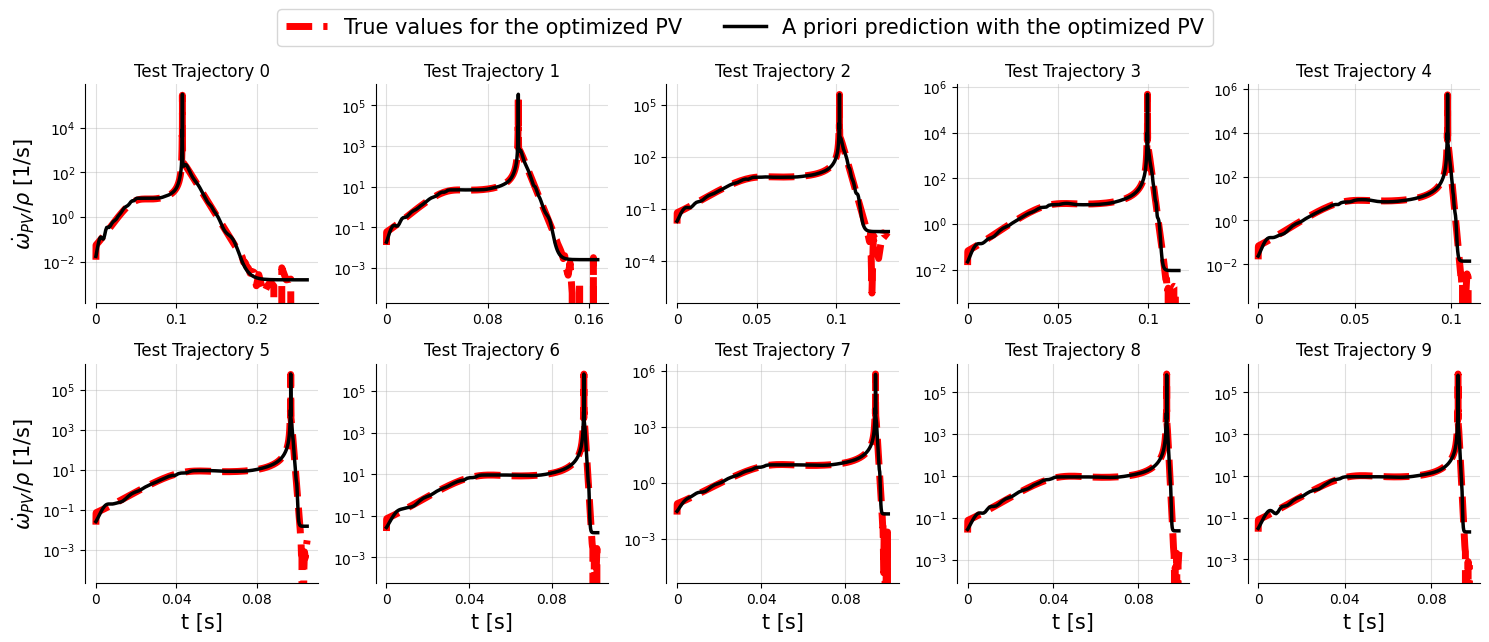

In [24]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"
name = f"Apriori_ANN_{regression_modelname_optimized}.png"
namePdf = f"Apriori_ANN_{regression_modelname_optimized}.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

def zero_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        return f"{x:g}"

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    ax.plot(test_trajectory_time, PV_optimized_source_test, label="True values for the optimized PV", color = "red", linestyle = "--", linewidth = 5)
    ax.plot(test_trajectory_time, prediction_test_trajectories_optimized[i], label="A priori prediction with the optimized PV", color = "k", linewidth = 2.5)
    ax.set_title(f"Test Trajectory {i}")
    ax.set_yscale("log")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

    ax.xaxis.set_major_formatter(FuncFormatter(zero_formatter))
    
    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r'$\dot{\omega}_{PV} / \rho$ [1/s]', fontsize = 15)

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

C:\Windows\Temp\ipykernel_16556\3531840314.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


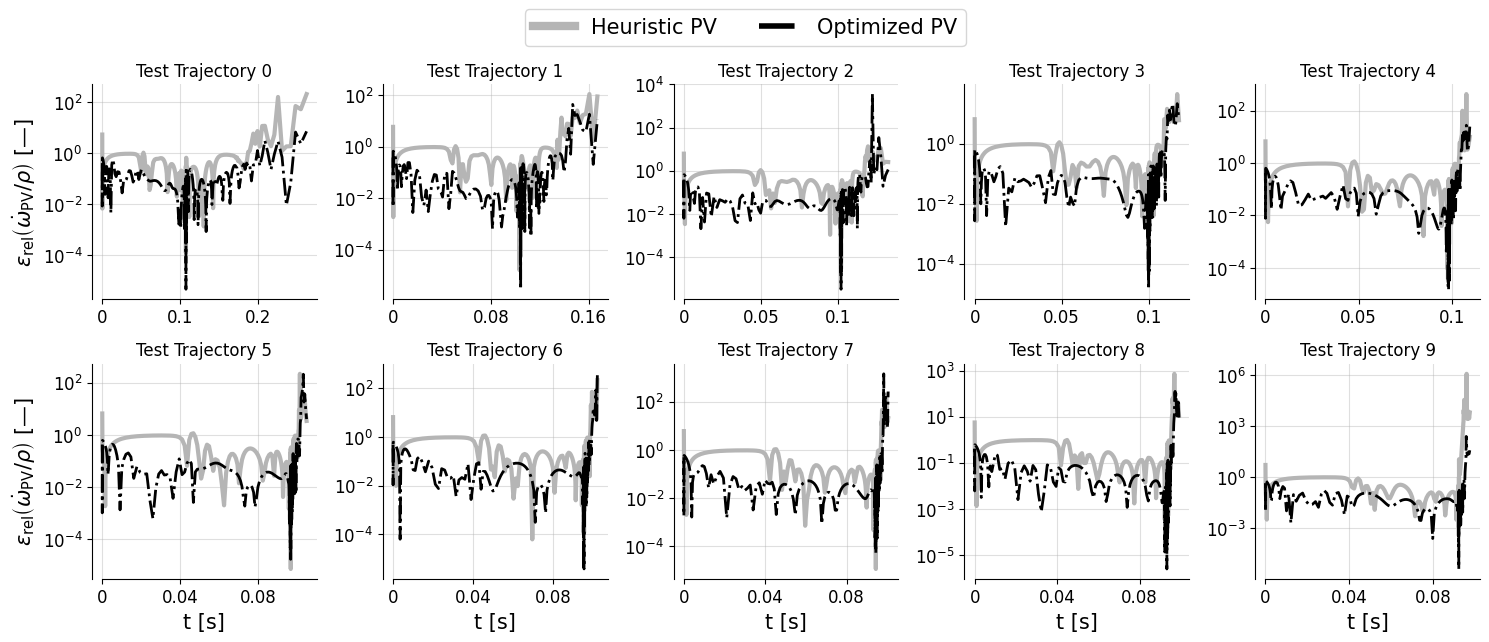

In [23]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"
name = f"Heuristic vs optimized {id_model} - A priori - relative Error comparison - ANN"
namePdf = f"Heuristic vs optimized {id_model} - A priori - relative Error comparison - ANN.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

greys = cm.get_cmap('Greys')

def zero_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        return f"{x:g}"  # keeps original formatting for other ticks

for i in range(num_test_trajectories):
    #test source terms
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
        test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
        PV_optimized_source_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))).detach().numpy()
        
        PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
        PV_Xu_source_test = PV_Xu_source_test.to_numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]
    relativeErrorXu = np.abs(PV_Xu_source_test.flatten() - prediction_test_trajectories[i].flatten())/np.abs(PV_Xu_source_test.flatten())
    relErrorOptimized = np.abs(prediction_test_trajectories_optimized[i].flatten() - PV_optimized_source_test.flatten())/np.abs(PV_optimized_source_test.flatten())
    ax.plot(test_trajectory_time, relativeErrorXu, label = "Heuristic PV", color = greys(0.4), linewidth = 3, linestyle = "-")
    ax.plot(test_trajectory_time, relErrorOptimized, label = "Optimized PV", color = "k", linewidth = 2, linestyle = "-.")
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yscale("log")
    ax.tick_params(axis='both', labelsize=12)
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax.grid(True, linestyle='-', alpha=0.4)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)
    
    ax.xaxis.set_major_formatter(FuncFormatter(zero_formatter))

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel(r"$\epsilon_{\mathrm{rel}}\left( \dot{\omega}_{\mathrm{PV}} / \rho \right)$" + " [\u2014]", fontsize=15)

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 2,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

## Figures for paper: A priori

C:\Windows\Temp\ipykernel_16556\1836449433.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greys = cm.get_cmap('Greys')


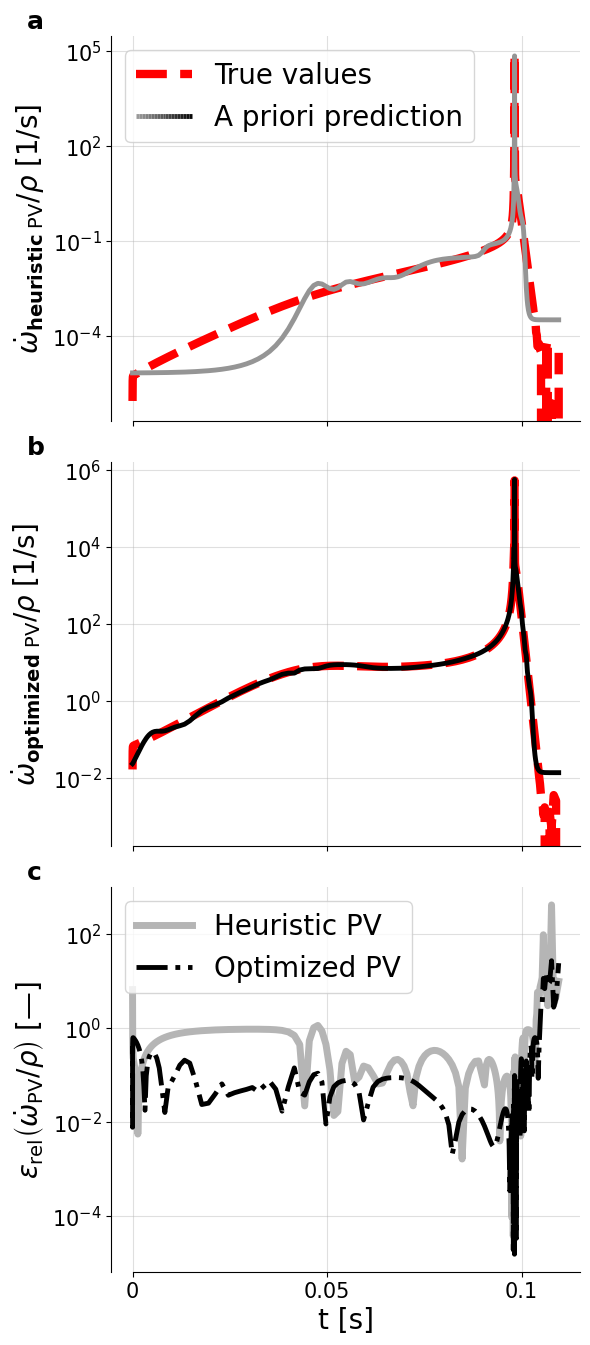

In [41]:
i = 4  # index of trajectory

save = False
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
name = f"Figure 10 - A priori PV model - heuristic vs optimized 2s_s2.png"
namePDF = f"Figure 10 - A priori PV model - heuristic vs optimized 2s_s2.pdf"

fig, axes = plt.subplots(3, 1, figsize=(6, 13.5))
greys = cm.get_cmap('Greys')

# -----------------------------
# Load data once for trajectory 4
# -----------------------------
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-sources-test-trajectories.h5", 'r') as hf:
    test_trajectory_source = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)
    state_space_source_test_DNS = test_trajectory_source[state_space_names_DNS].to_numpy()
    PV_optimized_source_test = PV_model.get_PV(
        torch.from_numpy(np.delete(state_space_source_test_DNS, idx_species_removed, axis=1))
    ).detach().numpy()

    PV_Xu_source_test = test_trajectory_source["H2O"] - test_trajectory_source["H2"] - test_trajectory_source["O2"]
    PV_Xu_source_test = PV_Xu_source_test.to_numpy()

with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])


class HandlerGradientLine(HandlerBase):
    def __init__(self, cmap, linewidth=3.5, **kwargs):
        super().__init__(**kwargs)
        self.cmap = cmap
        self.linewidth = linewidth

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):

        n = 20
        x = np.linspace(xdescent, xdescent + width, n)
        y = np.full(n, ydescent + height / 2)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(
            segments,
            cmap=self.cmap,
            linewidths=self.linewidth
        )
        lc.set_array(np.linspace(0, 1, n))
        lc.set_transform(trans)

        return [lc]



grey_black = LinearSegmentedColormap.from_list(
    "grey_black", ["0.6", "0.0"]
)

true_handle, = axes[0].plot(
    [], [], color="red", linestyle="--", linewidth=6,
    label="True values"
)

gradient_handle, = axes[0].plot(
    [], [], label="A priori prediction"
)

# -----------------------------
# Plot 1: Heuristic PV
# -----------------------------
ax = axes[0]
ax.plot(test_trajectory_time, PV_Xu_source_test,
        label="True values", color="red",
        linestyle="--", linewidth=6)
ax.plot(test_trajectory_time, prediction_test_trajectories[i],
        label="A priori prediction", color=greys(0.5),
        linewidth=3.5)
#ax.set_title(f"Trajectory {i}: A priori", fontsize = 15, fontweight="bold")
ax.set_yscale("log")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.set_xticklabels([])
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.grid(True, linestyle='-', alpha=0.4)
ax.tick_params(axis = "both", labelsize = 15)
ax.set_ylabel(r'$\dot{\omega}_{\mathbf{heuristic}\ \mathrm{PV}} / \rho$ [1/s]', fontsize=20)
ax.legend(
    handles=[true_handle, gradient_handle],
    labels=["True values", "A priori prediction"],
    handler_map={gradient_handle: HandlerGradientLine(grey_black)},
    fontsize=20,
    loc="upper left",
    ncols=1,
    frameon=True
)

# -----------------------------
# Plot 2: Optimized PV
# -----------------------------
ax = axes[1]
ax.plot(test_trajectory_time, PV_optimized_source_test,
        label="True values for the optimized PV", color="red",
        linestyle="--", linewidth=6)
ax.plot(test_trajectory_time, prediction_test_trajectories_optimized[i],
        label="A priori prediction with the optimized PV", color="k",
        linewidth=3.5)
ax.set_yscale("log")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: "0" if np.isclose(x, 0) else f"{x:g}")
)
ax.set_xticklabels([])
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.tick_params(axis = "both", labelsize = 15)
ax.grid(True, linestyle='-', alpha=0.4)
ax.set_ylabel(r'$\dot{\omega}_{\mathbf{optimized}\ \mathrm{PV}} / \rho$ [1/s]', fontsize=20)

# -----------------------------
# Plot 3: Relative Error
# -----------------------------
relativeErrorXu = np.abs(PV_Xu_source_test.flatten() - prediction_test_trajectories[i].flatten()) / np.abs(PV_Xu_source_test.flatten())
relErrorOptimized = np.abs(prediction_test_trajectories_optimized[i].flatten() - PV_optimized_source_test.flatten()) / np.abs(PV_optimized_source_test.flatten())

ax = axes[2]
ax.plot(test_trajectory_time, relativeErrorXu,
        label="Heuristic PV", color=greys(0.4), linewidth=5, linestyle="-")
ax.plot(test_trajectory_time, relErrorOptimized,
        label="Optimized PV", color="k", linewidth=3.5, linestyle="-.")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: "0" if np.isclose(x, 0) else f"{x:g}")
)
ax.set_yscale("log")
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
ax.grid(True, linestyle='-', alpha=0.4)
ax.set_xlabel("t [s]", fontsize=20)
ax.tick_params(axis = "both", labelsize = 15)
ax.set_ylabel(r"$\epsilon_{\mathrm{rel}}\left( \dot{\omega}_{\mathrm{PV}} / \rho \right)$" + " [\u2014]", fontsize=20)
ax.legend(fontsize = 20, ncols = 1, loc = "upper left")

for i in range(len(axes)):
    ax = axes[i]
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    offset = 8

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

def add_panel_label(ax, label, x_offset=-0.18, y_offset=1.07, fontsize=18):
    ax.text(
        x_offset, y_offset,
        label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
        va="top",
        ha="left",
        clip_on=False
    )

add_panel_label(axes[0], "a")
add_panel_label(axes[1], "b")
add_panel_label(axes[2], "c")

# -----------------------------
# Adjust and save
# -----------------------------
plt.tight_layout()
if save:
    plt.savefig(pathSave + name, dpi=1000, bbox_inches="tight")
    plt.savefig(pathSave + namePDF, bbox_inches="tight")
plt.show()


---
<h3> PV optimized: Evolve the PV over time

In [26]:
class ODEOptimized(torch.nn.Module):

    def __init__(self, min_max_PV):
        super().__init__()
        self.min_PV = min_max_PV[0]
        self.max_PV = min_max_PV[1]

    def forward(self, t, y):
        y_scaled = y.clone() #avoid in place changes
        if scaledManifold_opt:
            y_scaled[1] = (y_scaled[1] - self.min_PV)/(self.max_PV - self.min_PV)
                
        
        #print(y)
        
        f_PV = (y_scaled-mins_input_optimized) / (maxs_input_optimized - mins_input_optimized) - 0.5
        PV_source_predicted = model_regression_optimized(f_PV)
        PV_source_predicted = (PV_source_predicted+1) /2 * (maxs_output_optimized - mins_output_optimized) + mins_output_optimized
        
        if(log_transform_opt == "continuous-symlog"):
            PV_optimized_source_test_predicted = inverse_symlog(PV_source_predicted, epsilon)
        elif(log_transform_opt == "log"):
            PV_optimized_source_test_predicted = 10**PV_source_predicted

        zero = torch.tensor([[0.0]], dtype=PV_optimized_source_test_predicted.dtype, device=PV_optimized_source_test_predicted.device)
        f_PV_source_predicted = torch.cat((zero, PV_optimized_source_test_predicted), dim=1) #add a zero for the mixture fraction
        

        return f_PV_source_predicted.squeeze()

In [27]:
idx_start_simulation = 0
list_simulations_optimized = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_test = torch.from_numpy(f_PV_optimized_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_test[idx_start_simulation,:]

    t_coordinates = test_trajectory_time[idx_start_simulation:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    
    ODEOptimized_instance = ODEOptimized([PV_optimized_test.min(), PV_optimized_test.max()])
    numerical_solution_optimized = odeint(ODEOptimized_instance, initial_condition, t_coordinates)#, method="rk4")
    list_simulations_optimized.append(numerical_solution_optimized) 

    MSE_optimized_test_simulation = mean_squared_error(PV_optimized_test[idx_start_simulation:], numerical_solution_optimized.squeeze()[:,1].detach().numpy())

    print(f"MSE for test trajectory {i}: {MSE_optimized_test_simulation}")

Predicted
MSE for test trajectory 0: 7.877221372146799
MSE for test trajectory 1: 13.926456565267479
MSE for test trajectory 2: 22.04926003790187
MSE for test trajectory 3: 26.767032670272737
MSE for test trajectory 4: 28.78203830412195
MSE for test trajectory 5: 25.480835140509917
MSE for test trajectory 6: 13.71512018809177
MSE for test trajectory 7: 18.219914532768392
MSE for test trajectory 8: 29.585384861673223
MSE for test trajectory 9: 34.042591660933134


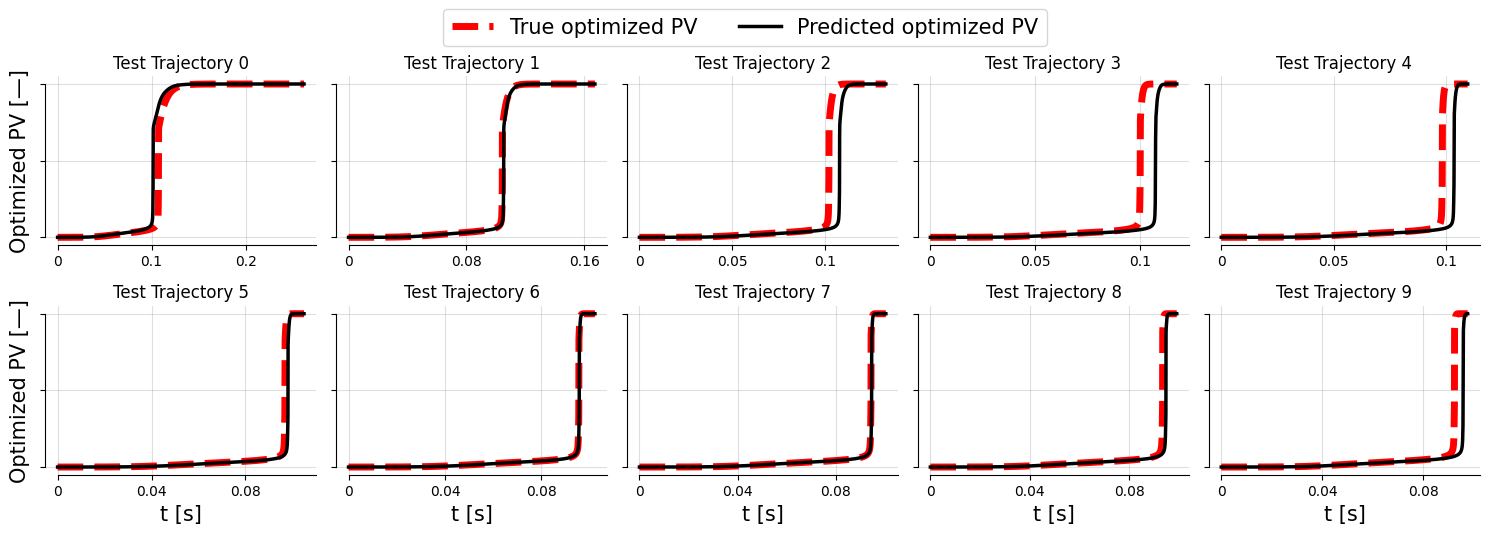

In [ ]:
save = True
zoom = False
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"


num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

def zero_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        return f"{x:g}"

for i in range(num_test_trajectories):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
        
    ax = axes[i]

    PV_min = PV_optimized_test[idx_start_simulation:].min()
    PV_max = PV_optimized_test[idx_start_simulation:].max()

    #-(list_simulations_optimized[i][:,1]-PV_min)/(PV_max - PV_min)+1

    if(zoom):
        ##############################################
        # Get the first and last index of the ignition
        ##############################################

        H2O_array = test_trajectory["H2O"].to_numpy()
        
        max_val = H2O_array.max()
        min_perc = 0.0028
        max_perc = 0.999
        lower_threshold = min_perc * max_val
        upper_threshold = max_perc * max_val

        idx_1 = np.searchsorted(H2O_array, lower_threshold, side='left')
        idx_99 = np.searchsorted(H2O_array, upper_threshold, side='left')

        ax.plot(test_trajectory_time[idx_1:idx_99], -(PV_optimized_test[idx_1:idx_99]-PV_min)/(PV_max - PV_min)+1, label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_1:idx_99], -(list_simulations_optimized[i][idx_1:idx_99,1]-PV_min)/(PV_max - PV_min)+1, label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    else:
        ax.plot(test_trajectory_time[idx_start_simulation:], (PV_optimized_test[idx_start_simulation:]-PV_min)/(PV_max - PV_min), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
        ax.plot(test_trajectory_time[idx_start_simulation:], (list_simulations_optimized[i][:,1].detach().numpy()-PV_min)/(PV_max - PV_min), label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    
    ax.set_title(f"Test Trajectory {i}")
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

    ax.spines["left"].set_bounds(0, 1)

    ax.xaxis.set_major_formatter(FuncFormatter(zero_formatter))

    ax.grid(True, linestyle='-', alpha=0.4)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

name = f"Heuristic vs optimized {id_model} - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.png"
namePdf = f"Heuristic vs optimized {id_model} - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}.pdf"

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

<h3> Run the a posteriori simulation longer

In [36]:
list_simulations_optimized_ext = []

#Get current date and time
now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

print("Predicted")

for i in range(10):

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

        f_PV_optimized_test = np.hstack((np.full(PV_optimized_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_optimized_test.reshape(-1,1)))
        f_PV_optimized_test = torch.from_numpy(f_PV_optimized_test).clone().detach()

        
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

    initial_condition = f_PV_optimized_test[0,:]

    t_coordinates = test_trajectory_time[0:].to_numpy().ravel()
    t_coordinates = torch.tensor(t_coordinates)
    deltaTime = t_coordinates[-1] - t_coordinates[-2]

    last_value = t_coordinates[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        t_coordinates = torch.cat((t_coordinates, extension))
    
    ODEOptimized_instance = ODEOptimized([PV_optimized_test.min(), PV_optimized_test.max()])
    numerical_solution_optimized = odeint(ODEOptimized_instance, initial_condition, t_coordinates)#, method="rk4")
    list_simulations_optimized_ext.append(numerical_solution_optimized) 

Predicted


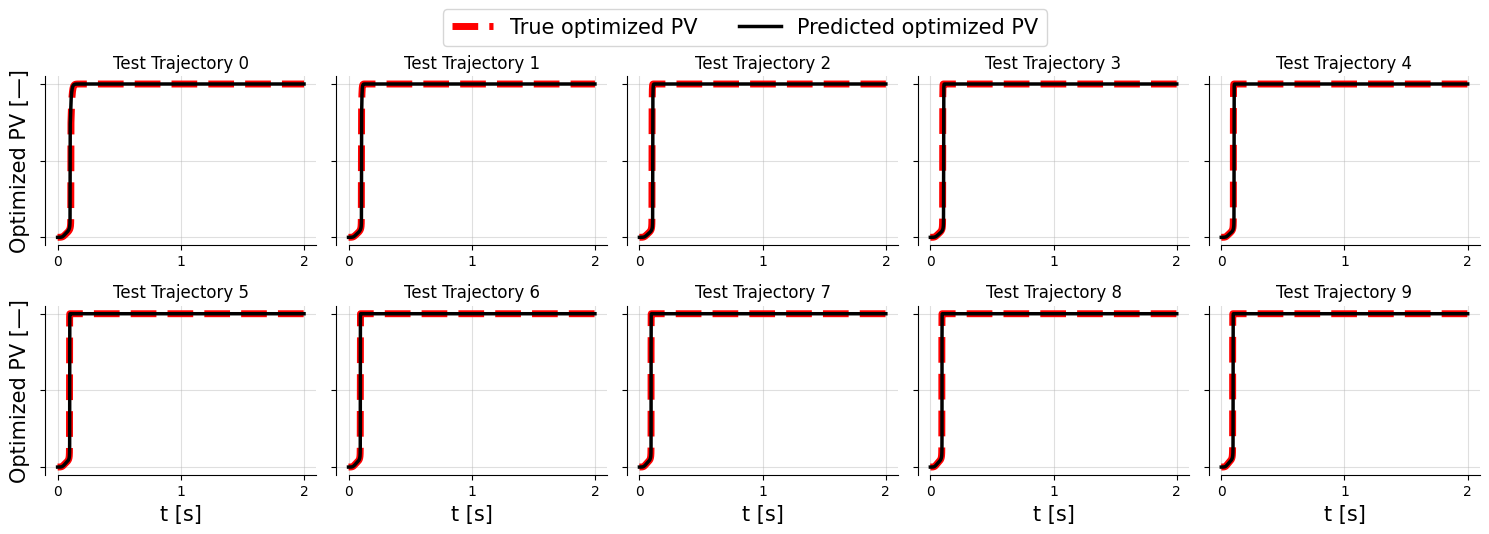

In [37]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"
name = f"Heuristic vs optimized - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.png"
namePdf = f"Heuristic vs optimized - A posteriori - Optimized PV - ANN {regression_modelname_optimized}{f' - zoom {min_perc}-{max_perc}' if zoom else ''}_timeExt.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(rows, cols, figsize=(15, 5))  # Define the grid
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_optimized_test
        PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value
    
    min_PV = PV_optimized_test.min()
    max_PV = PV_optimized_test.max()
    
    ax = axes[i]
    ax.plot(test_trajectory_time_ext, (PV_optimized_test_ext-min_PV)/(max_PV-min_PV), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
    ax.plot(test_trajectory_time_ext, (list_simulations_optimized_ext[i].squeeze()[:,1].detach().numpy()-min_PV)/(max_PV-min_PV), label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
    ax.set_title(f"Test Trajectory {i}")
    ax.set_xticks([0, 1 , 2])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])

    ax.grid(True, linestyle='-', alpha=0.4)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

    if(i>=num_test_trajectories-cols):
            ax.set_xlabel(f"t [s]", fontsize = 15)
    
    if(i%cols == 0):
            ax.set_ylabel('Optimized PV [\u2014]', fontsize = 15)    

#hide empty figures
for j in range(num_test_trajectories, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
custom_handles = [
    Line2D([0], [0], color=handle.get_color(),
           linestyle=handle.get_linestyle(),
           linewidth=handle.get_linewidth() * 1,  # Increase legend linewidth
           label=label)
    for handle, label in zip(handles, labels)
]
fig.legend(custom_handles, labels, loc='upper center', ncol=2, fontsize=15, frameon=True, bbox_to_anchor=(0.5, 1.08))

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=300, bbox_inches = "tight")
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()

In [20]:
def ignition_time_difference(time_array, pv_true, pv_pred, threshold=0.99):
    """
    Compute the time difference between true and predicted PV ignition times.
    
    Parameters
    ----------
    time_array : np.ndarray
        1D array of time values.
    pv_true : np.ndarray
        1D array of true PV values (same length as time_array).
    pv_pred : np.ndarray
        1D array of predicted PV values (same length as time_array).
    threshold : float, optional
        The PV threshold for ignition (default: 0.99).
    
    Returns
    -------
    float or None
        The time difference (predicted - true) when both trajectories reach
        the threshold. Returns None if either trajectory never reaches it.
    """
    # Find first index where true PV >= threshold
    true_idx = np.argmax(pv_true >= threshold) if np.any(pv_true >= threshold) else None
    # Find first index where predicted PV >= threshold
    pred_idx = np.argmax(pv_pred >= threshold) if np.any(pv_pred >= threshold) else None

    if true_idx is None or pred_idx is None:
        return None  # one of them never reaches threshold

    true_time = time_array[true_idx]
    pred_time = time_array[pred_idx]

    return np.round(pred_time - true_time, 3), np.round(np.abs(pred_time - true_time)/pred_time*100, 3)

for i in range(10):
    #test state space
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])
    
    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = PV_optimized_test[-1]
        extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
        PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value

    min_PV = PV_optimized_test_ext.min()
    max_PV = PV_optimized_test_ext.max()

    true_PV_norm = (PV_optimized_test_ext - min_PV) / (max_PV - min_PV)
    pred_PV_norm = (list_simulations_optimized_ext[i].squeeze()[:,1].detach().numpy() - min_PV) / (max_PV - min_PV)

    # Compute ignition time difference
    dt, perc = ignition_time_difference(np.array(test_trajectory_time_ext), true_PV_norm, pred_PV_norm)
    print(f"Ignition time difference of traj {i}:", dt, f"s - {perc}%")

Ignition time difference of traj 0: -0.006 s - 5.128%
Ignition time difference of traj 1: 0.001 s - 0.799%
Ignition time difference of traj 2: 0.006 s - 5.305%
Ignition time difference of traj 3: 0.008 s - 6.896%
Ignition time difference of traj 4: 0.005 s - 5.163%
Ignition time difference of traj 5: 0.001 s - 1.333%
Ignition time difference of traj 6: 0.0 s - 0.154%
Ignition time difference of traj 7: 0.0 s - 0.245%
Ignition time difference of traj 8: 0.001 s - 1.418%
Ignition time difference of traj 9: 0.004 s - 3.893%


## A posteriori: PV trajectory

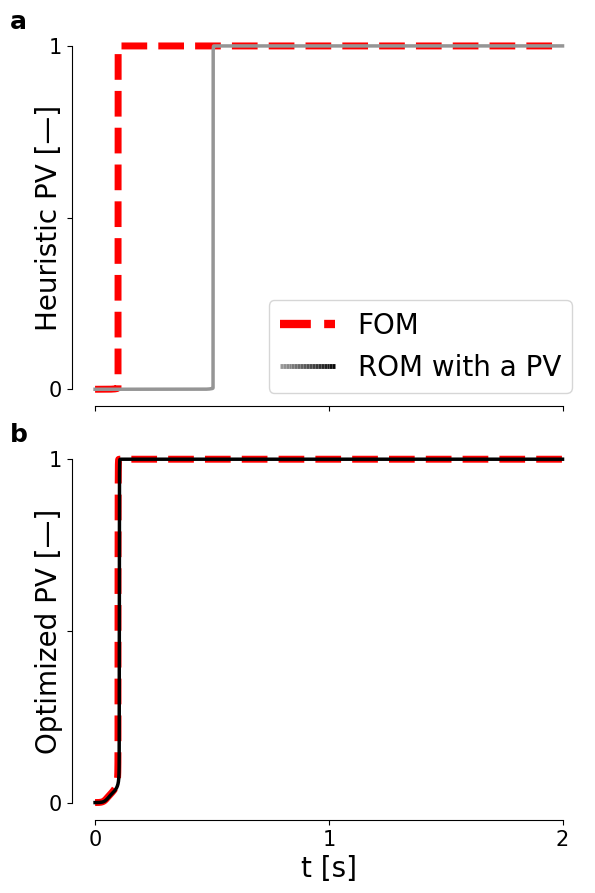

In [44]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
name = f"Figure 11 - A posteriori PV model - heuristic vs optimized 2s_s2 - label.png"
namePDF = f"Figure 11 - A posteriori PV model - heuristic vs optimized 2s_s2 - label.pdf"

num_test_trajectories = 10
rows, cols = 2, 5  # Arrange in a 2x5 grid

fig, axes = plt.subplots(2, 1, figsize=(6, 9))  # 2 rows, 1 column
ax1, ax2 = axes

i = 4

#-------------------------
# Heuristic PV
#-------------------------

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
    if(Xu_H2O == "H2O"):
        PV_Xu_test = test_trajectory["H2O"]
    elif(Xu_H2O == "Xu"):
        PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)
    f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1,1), PV_Xu_test))

#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

test_trajectory_time = test_trajectory_time.to_numpy().ravel()
test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

last_value = test_trajectory_time[-1]
new_times = []

next_time = last_value + deltaTime
while next_time <= 2:
    new_times.append(next_time.item())
    next_time += deltaTime

#Add extension to the current tensor
if new_times:
    extension = torch.tensor(new_times, dtype=torch.float32)
    test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

    last_value = PV_Xu_test[-1]
    extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_Xu_test
    PV_Xu_test_ext = np.vstack((PV_Xu_test, extension)) #concatenate the extension with the original value

min_PV = PV_Xu_test_ext.min()
max_PV = PV_Xu_test_ext.max()

ax1.plot(test_trajectory_time_ext, (PV_Xu_test_ext-min_PV)/(max_PV - min_PV), label="FOM", color = "red", linestyle = "--", linewidth = 5)
ax1.plot(test_trajectory_time_ext, (list_simulations_Xu_ext[i][:,1].detach().numpy()-min_PV)/(max_PV - min_PV), label="ROM with a PV", color = greys(0.5), linewidth = 2.5)
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels([])
ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels(["0", "", "1"])
ax1.tick_params(axis = "y", labelsize = 15)
#ax1.grid(True, linestyle='-', alpha=0.4)

ax1.set_ylabel('Heuristic PV [\u2014]', fontsize = 20, labelpad = -10)

ax1.spines["bottom"].set_bounds(0, 2)
ax1.spines["left"].set_bounds(0, 1)

true_handle, = axes[0].plot(
    [], [], color="red", linestyle="--", linewidth=6,
    label="FOM"
)

gradient_handle, = axes[0].plot(
    [], [], label="ROM with a PV"
)
ax1.legend(
    handles=[true_handle, gradient_handle],
    labels=["FOM", "ROM with a PV"],
    handler_map={gradient_handle: HandlerGradientLine(grey_black)},
    fontsize=20,
    loc="lower right",
    ncols=1,
    frameon=True
)


#-------------------------
# Optimized PV
#-------------------------

#test state space
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:])

test_trajectory_time = test_trajectory_time.to_numpy().ravel()
test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

last_value = test_trajectory_time[-1]
new_times = []

next_time = last_value + deltaTime
while next_time <= 2:
    new_times.append(next_time.item())
    next_time += deltaTime

#Add extension to the current tensor
if new_times:
    extension = torch.tensor(new_times, dtype=torch.float32)
    test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

    last_value = PV_optimized_test[-1]
    extension = np.tile(last_value, (len(new_times), 1))  #extension with last value of PV_optimized_test
    PV_optimized_test_ext = np.vstack((PV_optimized_test, extension)) #concatenate the extension with the original value

min_PV = PV_optimized_test.min()
max_PV = PV_optimized_test.max()

ax2.plot(test_trajectory_time_ext, (PV_optimized_test_ext-min_PV)/(max_PV-min_PV), label="True optimized PV", color = "red", linestyle = "--", linewidth = 5) #id_end
ax2.plot(test_trajectory_time_ext, (list_simulations_optimized_ext[i].squeeze()[:,1].detach().numpy()-min_PV)/(max_PV-min_PV), label="Predicted optimized PV", color = "k", linewidth = 2.5) #idx_end-idx_start_simulation
ax2.set_xticks([0, 1 , 2])
ax2.set_yticks([0, 0.5, 1])
ax2.set_yticklabels(["0", "", "1"])
ax2.tick_params(axis = "both", labelsize = 15)

#ax2.grid(True, linestyle='-', alpha=0.4)

ax2.set_xlabel(f"t [s]", fontsize = 20)
    
ax2.set_ylabel('Optimized PV [\u2014]', fontsize = 20, labelpad = -10)
ax2.spines["bottom"].set_bounds(0, 2)
ax2.spines["left"].set_bounds(0, 1)  

for i in range(len(axes)):
    ax = axes[i]
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def add_panel_label(ax, label, x_offset=-0.12, y_offset=1.05, fontsize=18):
    ax.text(
        x_offset, y_offset,
        label,
        transform=ax.transAxes,
        fontsize=fontsize,
        fontweight="bold",
        va="top",
        ha="left",
        clip_on=False
    )

add_panel_label(ax1, "a")
add_panel_label(ax2, "b")

# Adjust layout
plt.tight_layout()
if(save):
    plt.savefig(pathSave + name, dpi=1000, bbox_inches = "tight")
    plt.savefig(pathSave + namePDF, bbox_inches = "tight")
plt.show()

<h3> Reconstruction to the full state space

In [34]:
#Load the model

with open(f'{path_regression_model}{regression_full_modelname_optimized}_metadata.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
model_params = loaded_dict["model_params"]

mins_input_full_optimized = loaded_dict["mins_input"]
maxs_input_full_optimized = loaded_dict["maxs_input"]
mins_output_full_optimized = loaded_dict["mins_output"]
maxs_output_full_optimized = loaded_dict["maxs_output"]

scaledManifold_full_opt = loaded_dict["scaleManifold"]

neuron_layers = loaded_dict["neuron_layers"]
max_epo = loaded_dict["max_epo"]

model_regression_full_optimized = ANN_regression(**model_params)
model_regression_full_optimized.load_state_dict(torch.load(f"{path_regression_model}{regression_full_modelname_optimized}_model.pth", weights_only=False))

print(f"Final MSE: {loaded_dict['final validation error']}")

Output_species = loaded_dict["Output_species"]

for i in range(10):
    f_PV_array = list_simulations_optimized[i][:].clone()


    if(scaledManifold_full_opt):
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_array[:, 1] = (f_PV_array[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    f_PV_array_scaled = (f_PV_array - mins_input_full_optimized)/(maxs_input_full_optimized - mins_input_full_optimized) - 0.5
    prediction_optimized = model_regression_full_optimized(f_PV_array_scaled)

Final MSE: 6.41537521177016e-06


<h3> Comparison of the heuristic PV with the optimized PV

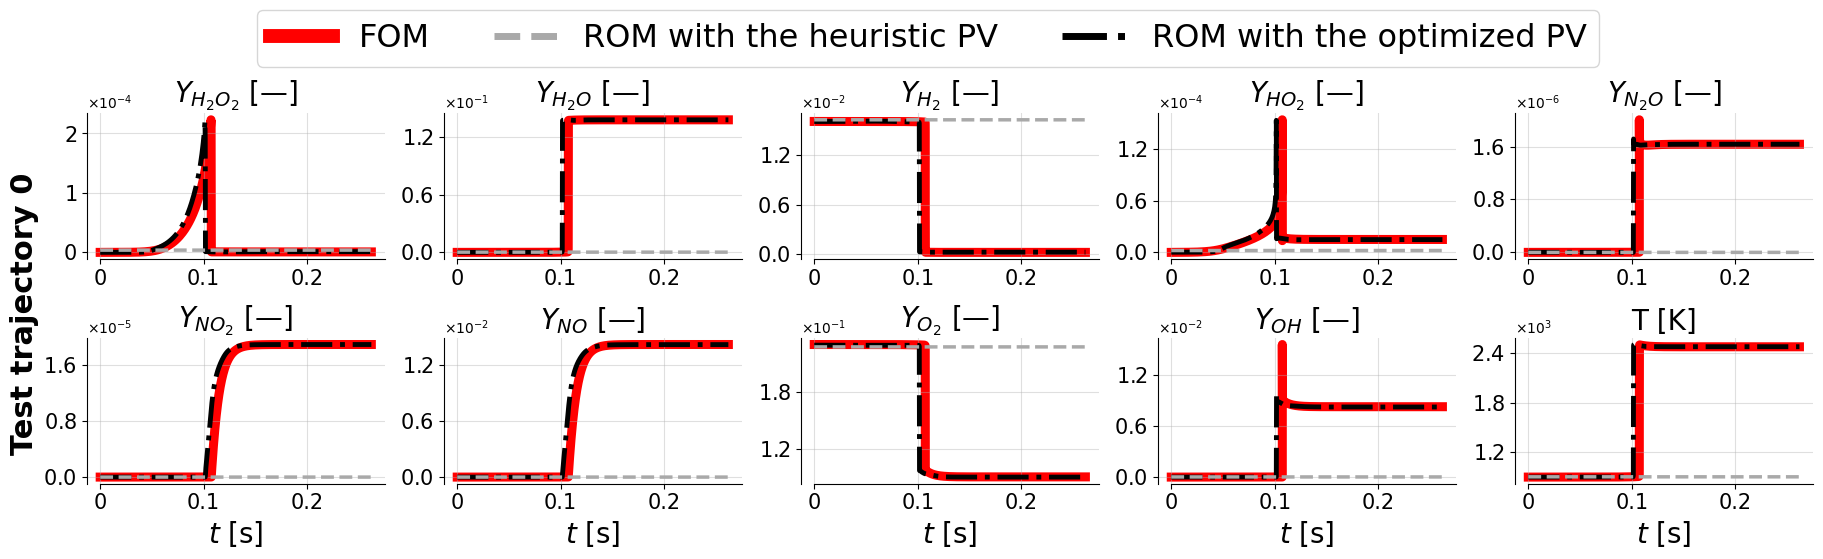

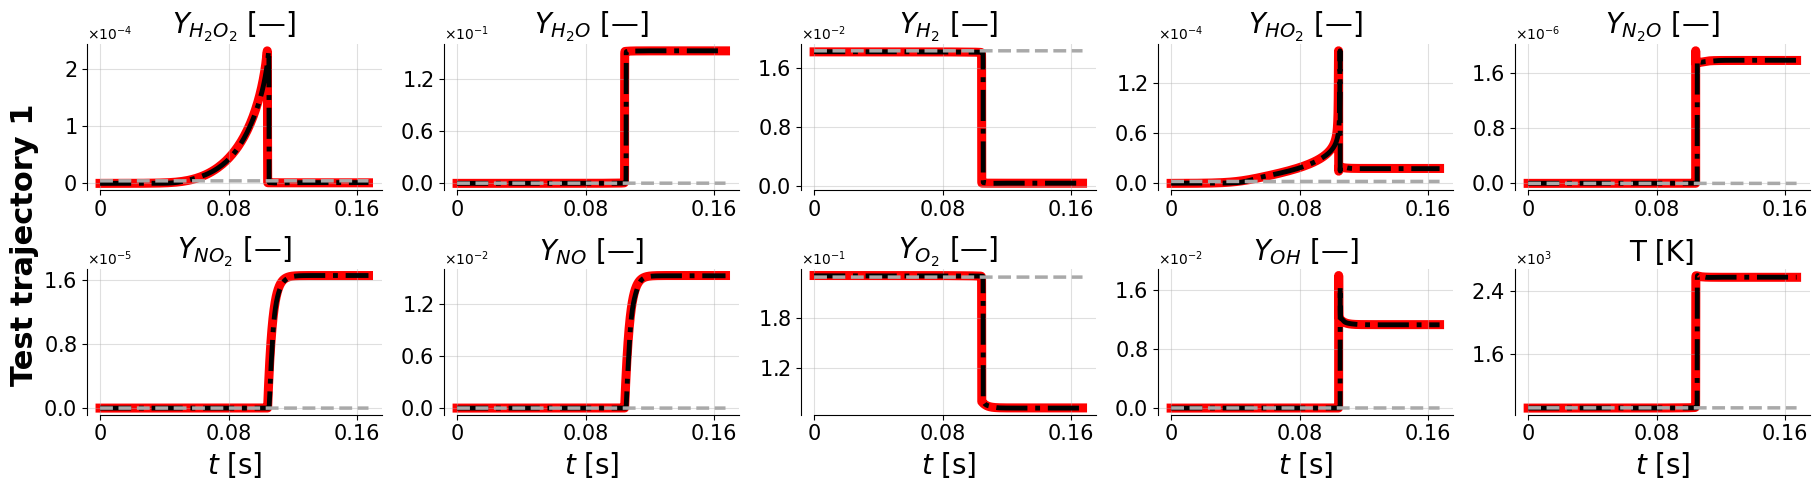

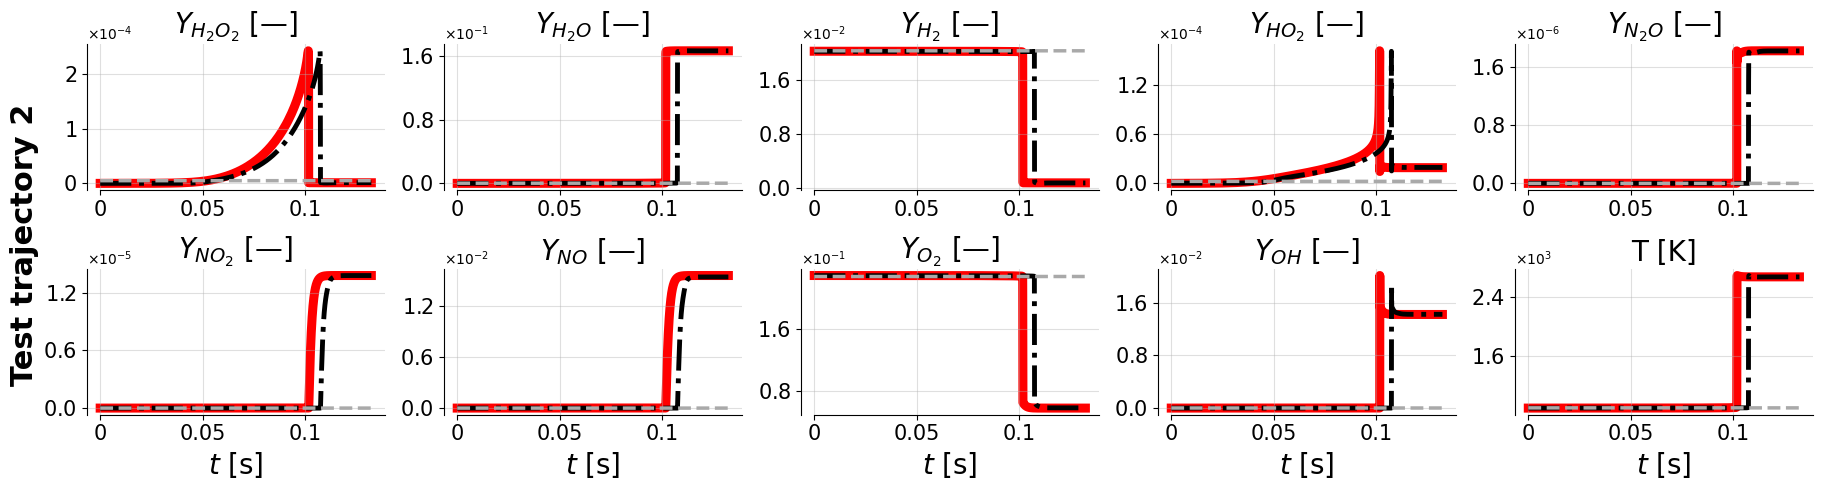

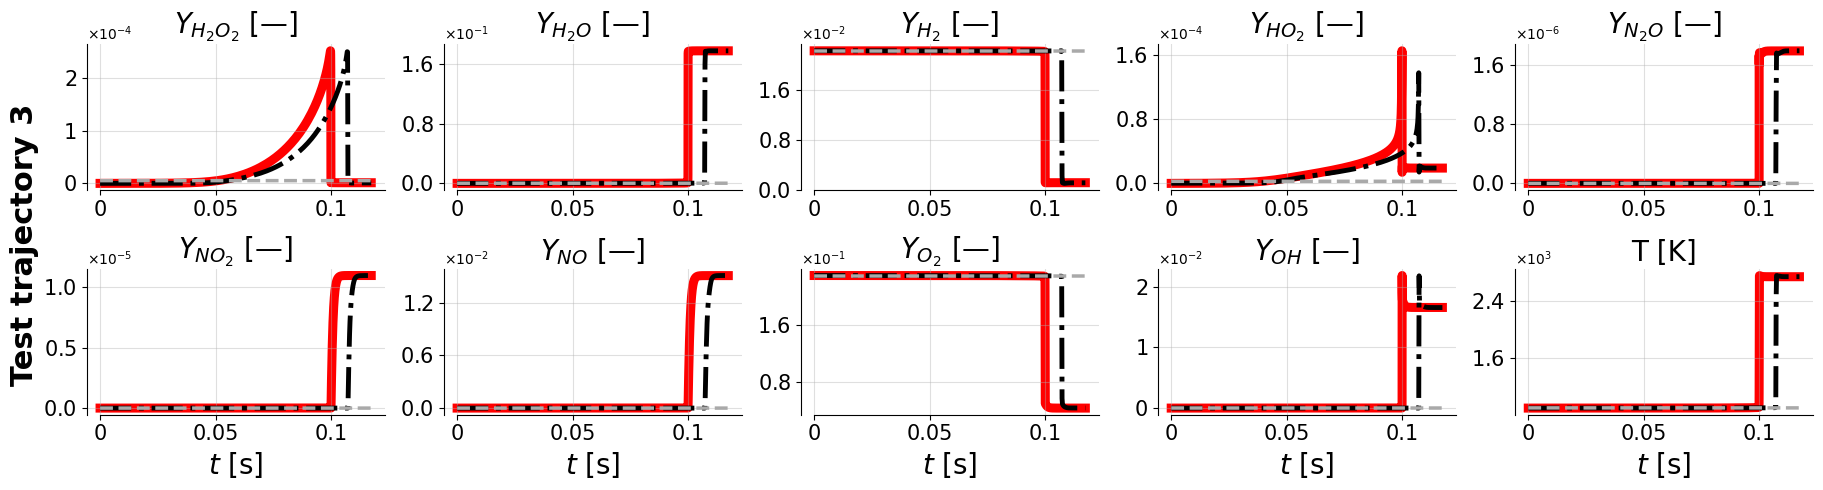

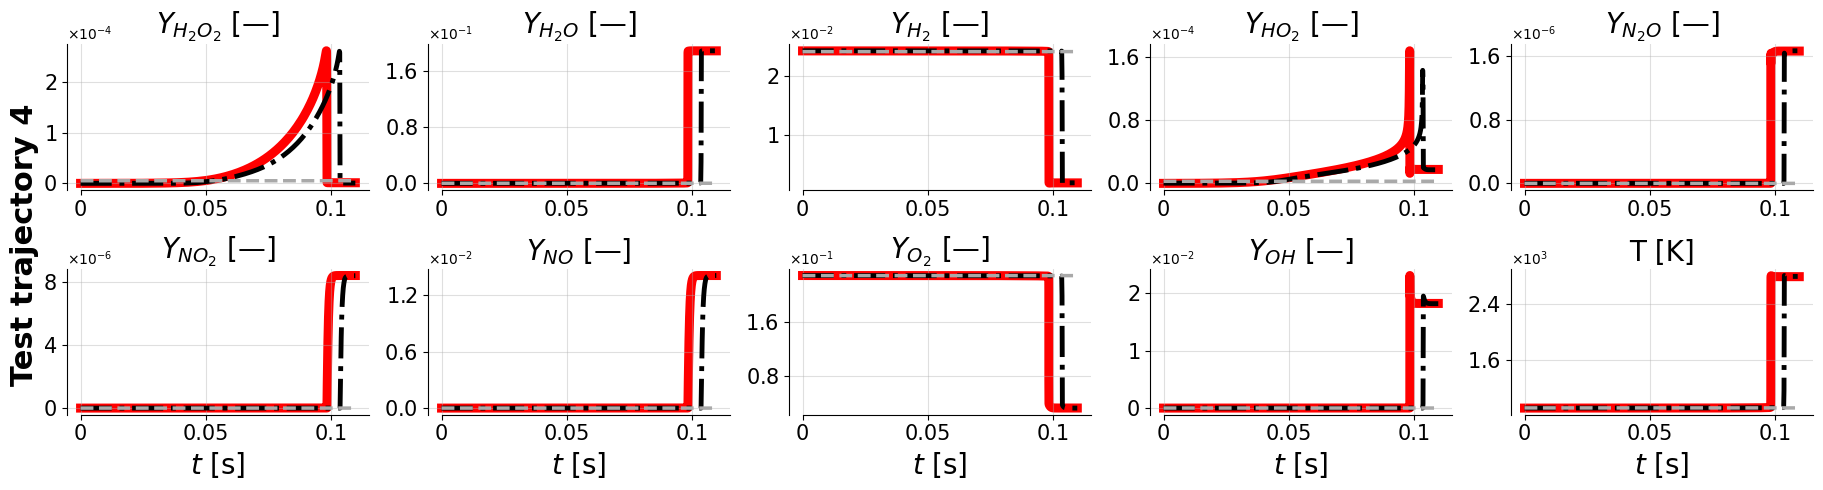

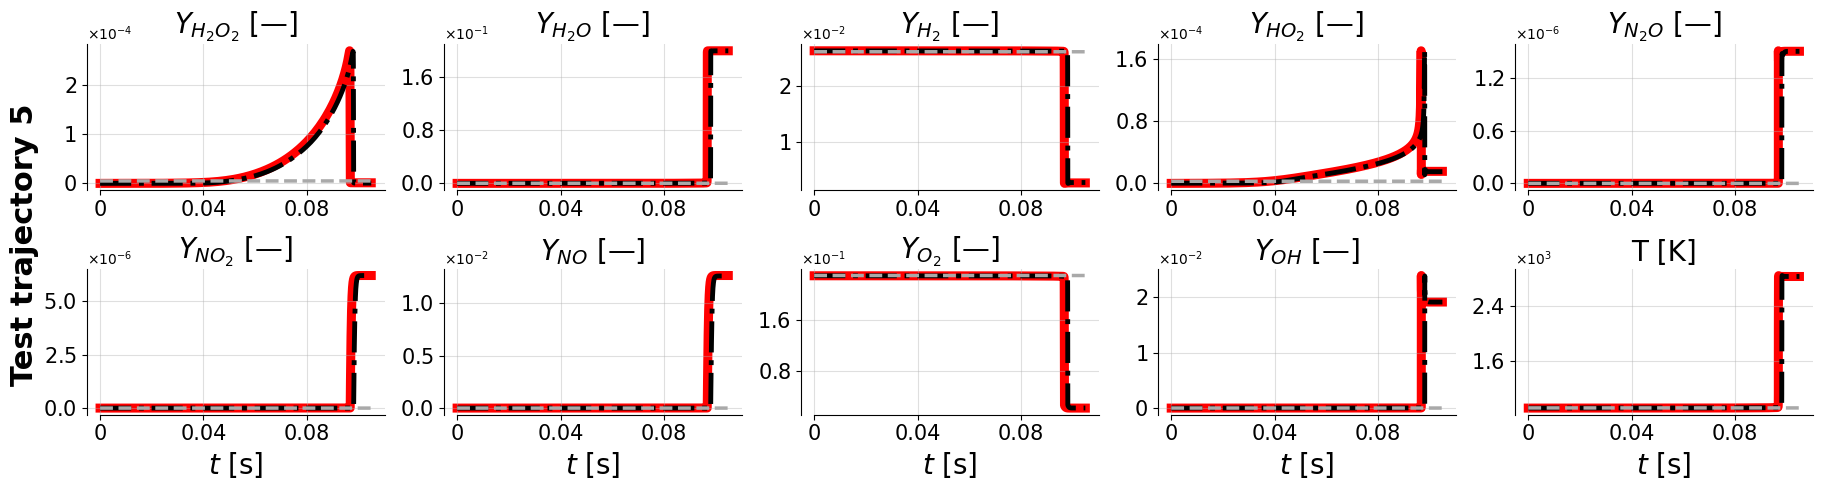

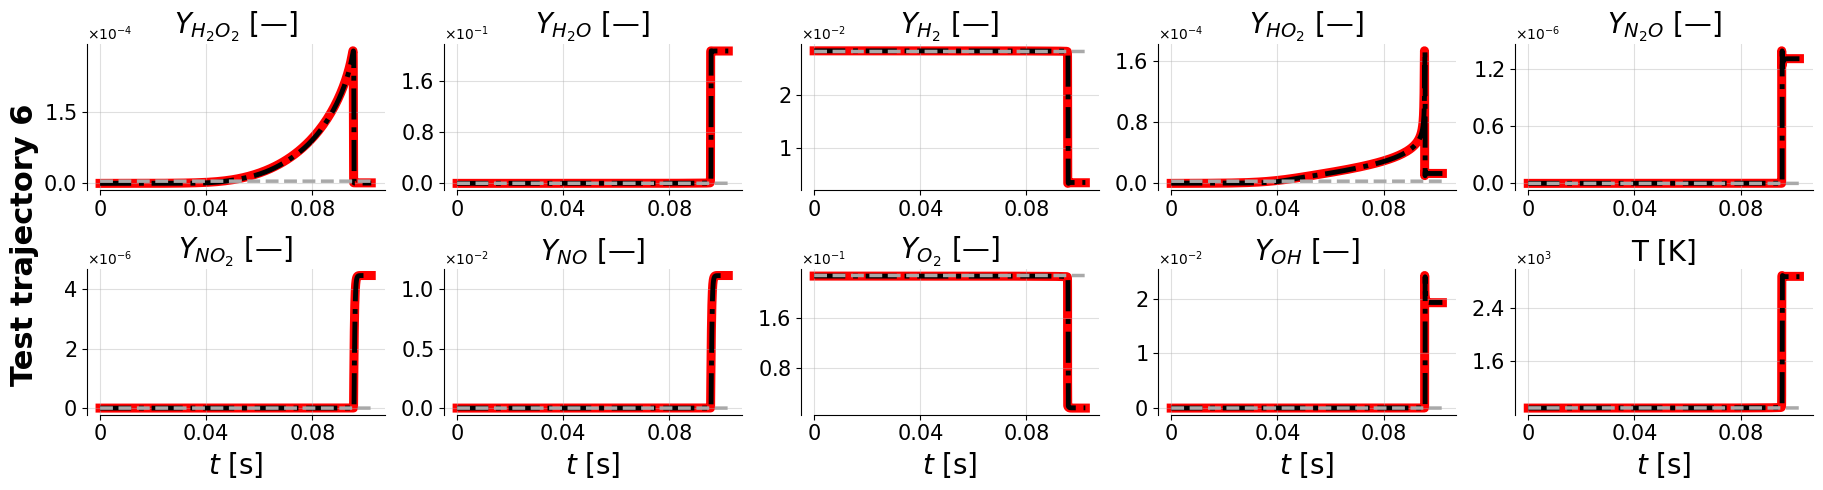

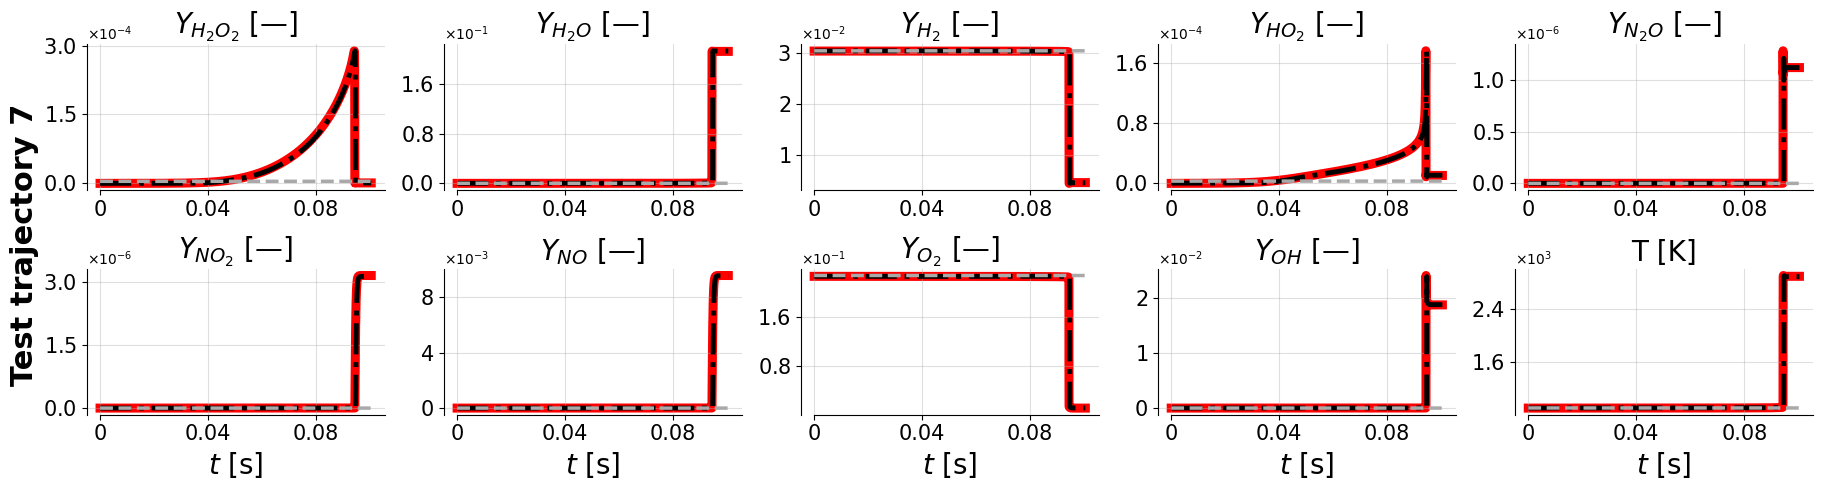

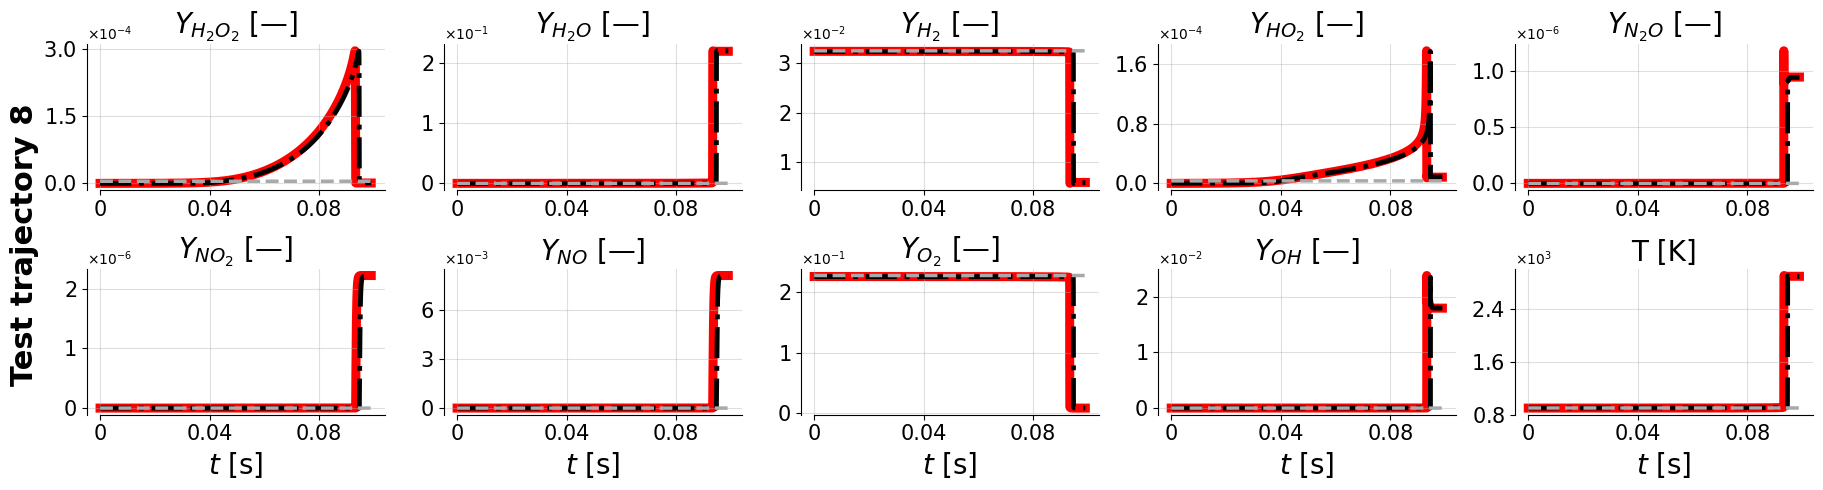

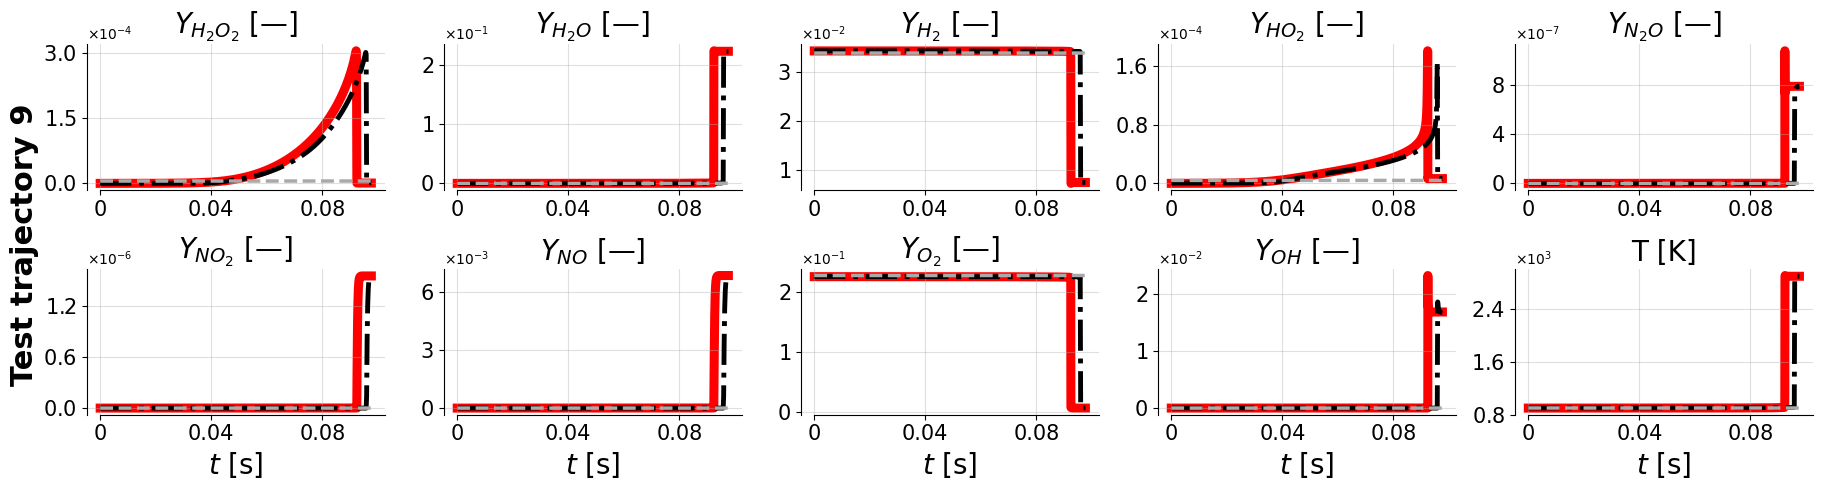

In [39]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"
name = f"Heuristic vs optimized {id_model} - A posteriori - ANN"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

num_test_trajectories = 10

def zero_formatter(x, pos):
    if x == 0:
        return "0"
    else:
        return f"{x:g}"

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])

    f_PV_Xu = list_simulations_Xu[idxSimulation][:].detach().clone()

    if(scaledManifold_full_Xu):
      with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names) 
            if(Xu_H2O == "H2O"):
                PV_Xu_test = test_trajectory["H2O"]
            elif(Xu_H2O == "Xu"):
                PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
            
            PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

      f_PV_Xu[:, 1] = (f_PV_Xu[:, 1] - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    f_PV_opt = list_simulations_optimized[idxSimulation][:].clone()

    if(scaledManifold_full_opt):
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_opt[:, 1] = (f_PV_opt[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())
    
    prediction_Xu = (model_regression_full_Xu((f_PV_Xu-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5) + 1) /2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
    prediction_Xu = prediction_Xu.detach().numpy()

    prediction_optimized = (model_regression_full_optimized((f_PV_opt-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5) + 1) /2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
    prediction_optimized = prediction_optimized.detach().numpy()
    
    for idxQoI in range(len(Output_species)): 
      ax = axes[idxQoI]
      
      ax.plot(test_trajectory_time, test_trajectory[Output_species[idxQoI]], label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time, prediction_Xu[:, idxQoI], label = "ROM with the heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time, prediction_optimized[:, idxQoI], label = "ROM with the optimized PV", c="k", linestyle="dashdot", linewidth=3.5, zorder = 2)
      
      if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)

      ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      formatter = ScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))
      ax.yaxis.set_major_formatter(formatter)
      ax.grid(True, linestyle='-', alpha=0.4)

      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)

      xmin, xmax = ax.get_xlim()
      ax.spines["bottom"].set_bounds(0, xmax)

      ax.xaxis.set_major_formatter(FuncFormatter(zero_formatter))
          
    for j in range(len(Output_species), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the heuristic PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with the optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout() #h_pad = 0

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()

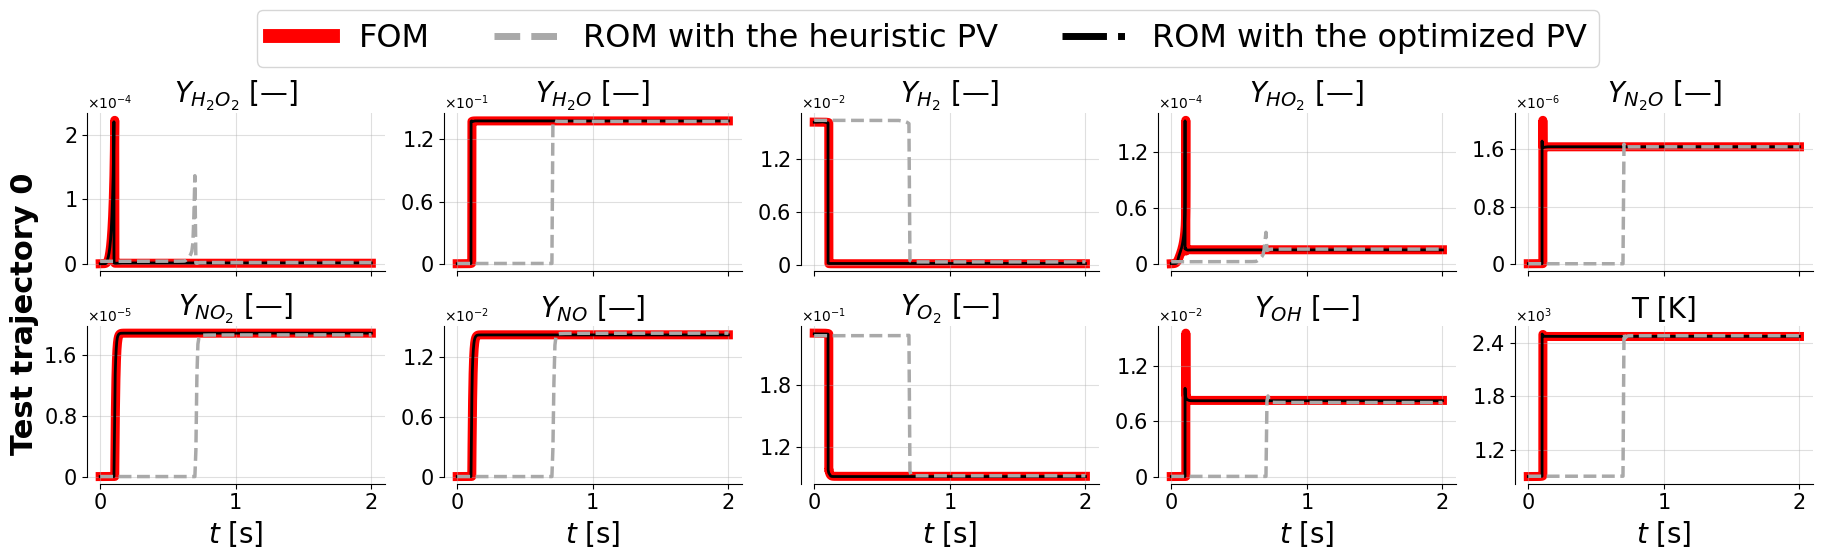

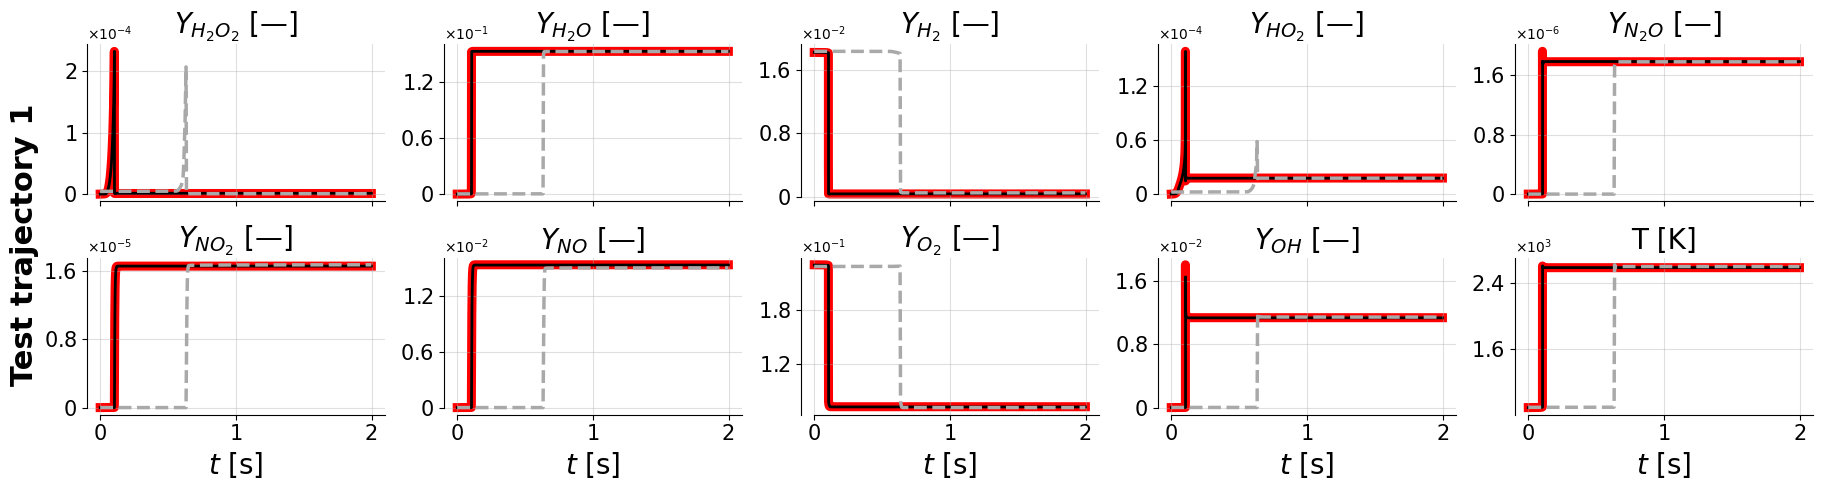

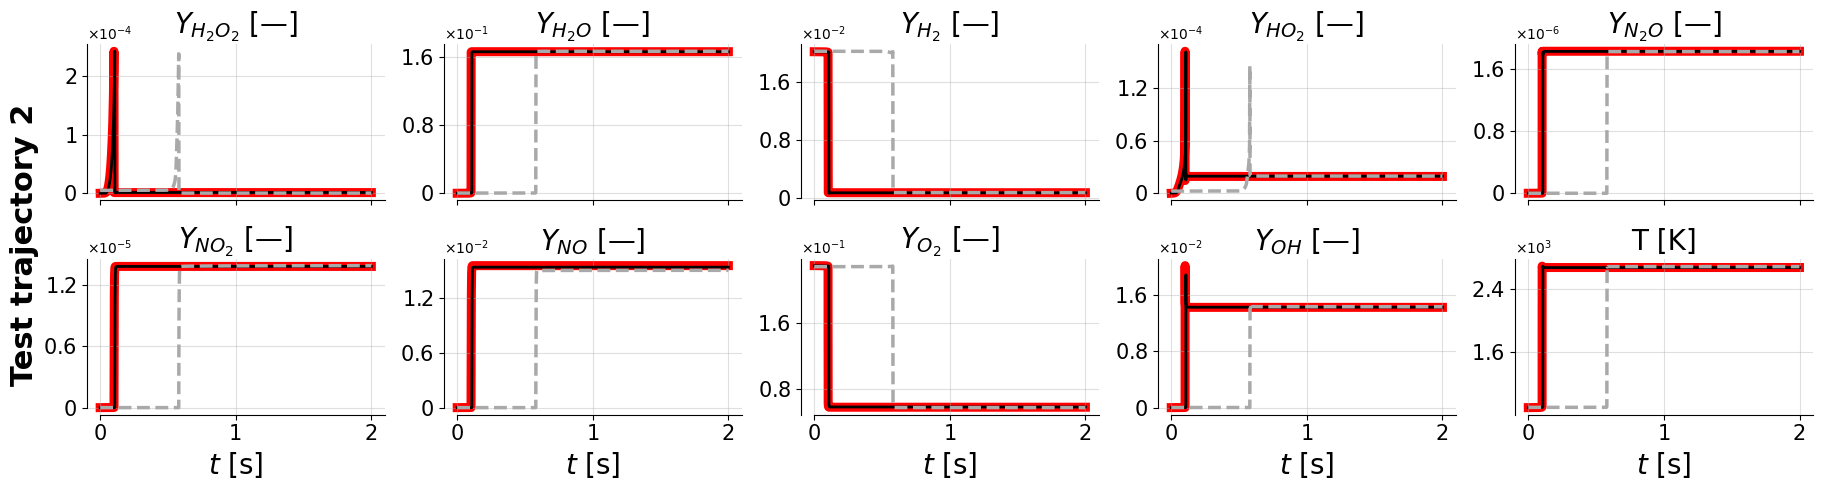

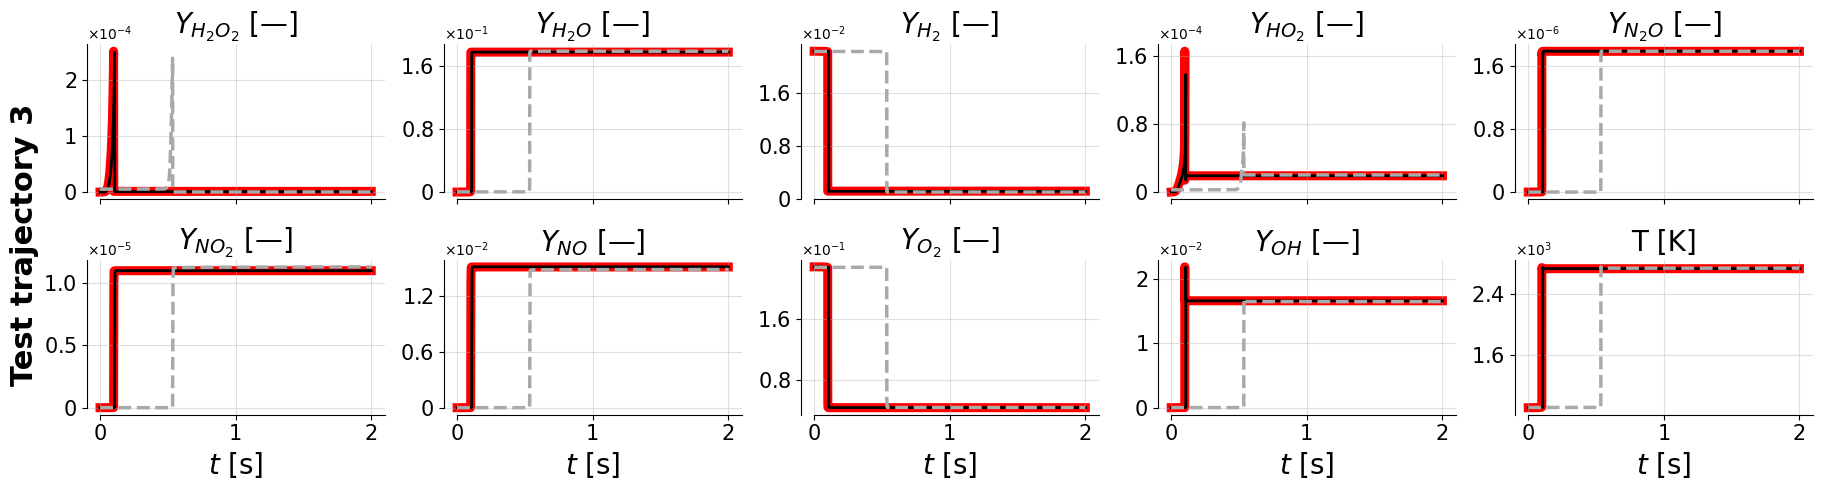

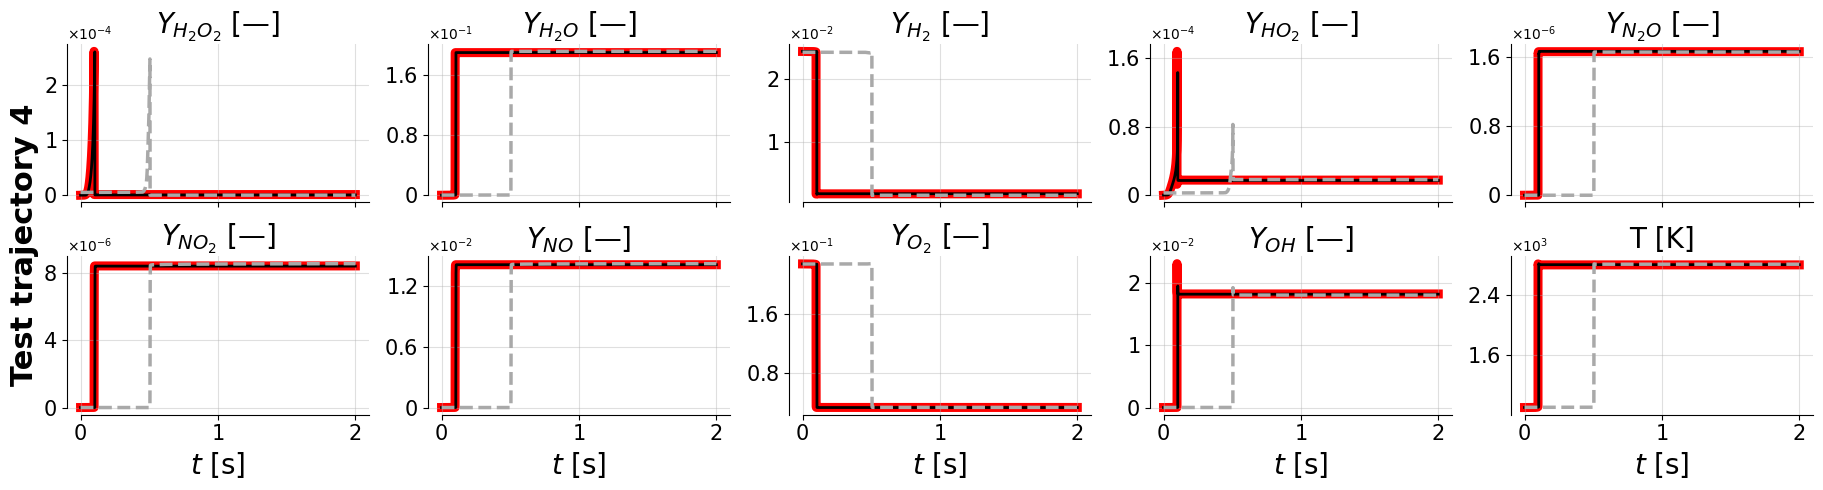

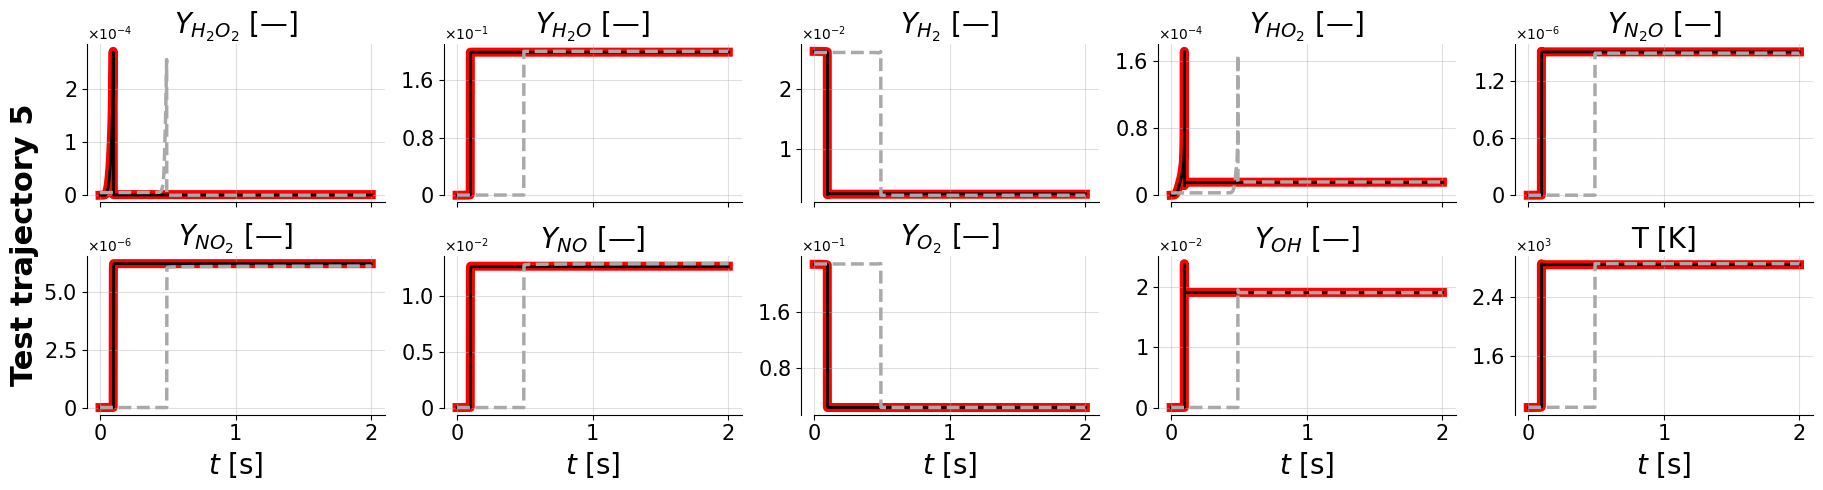

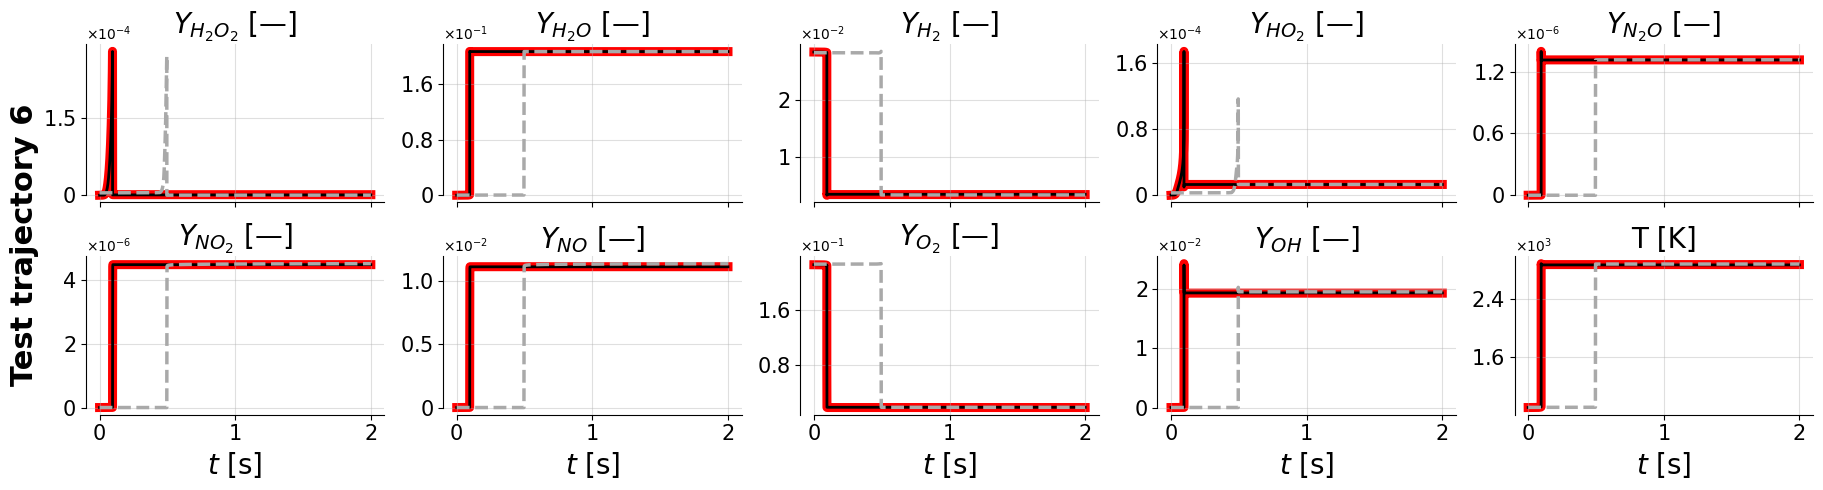

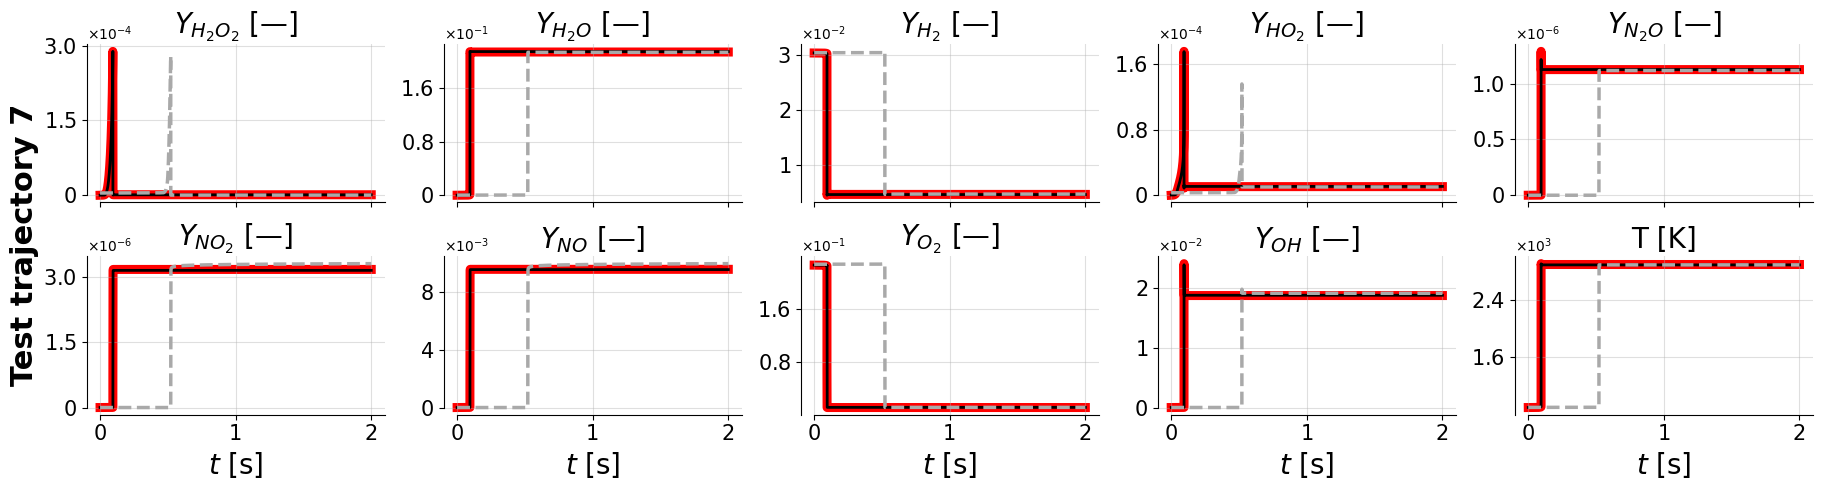

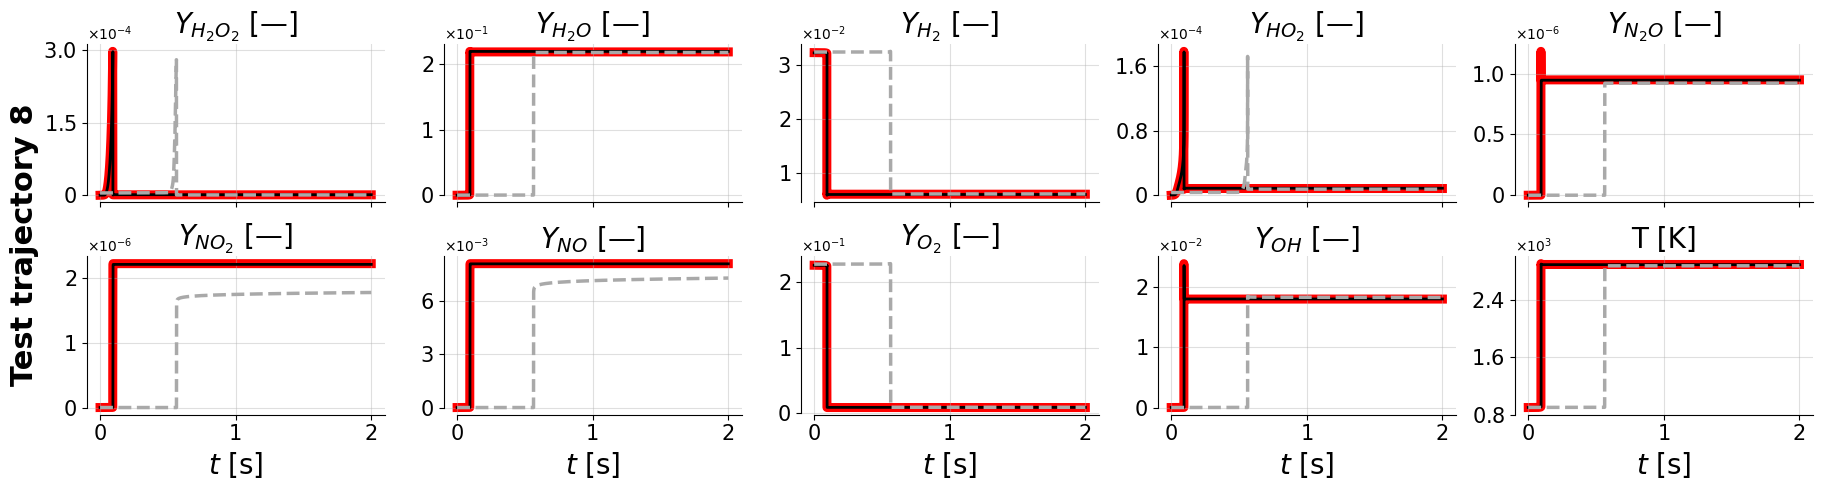

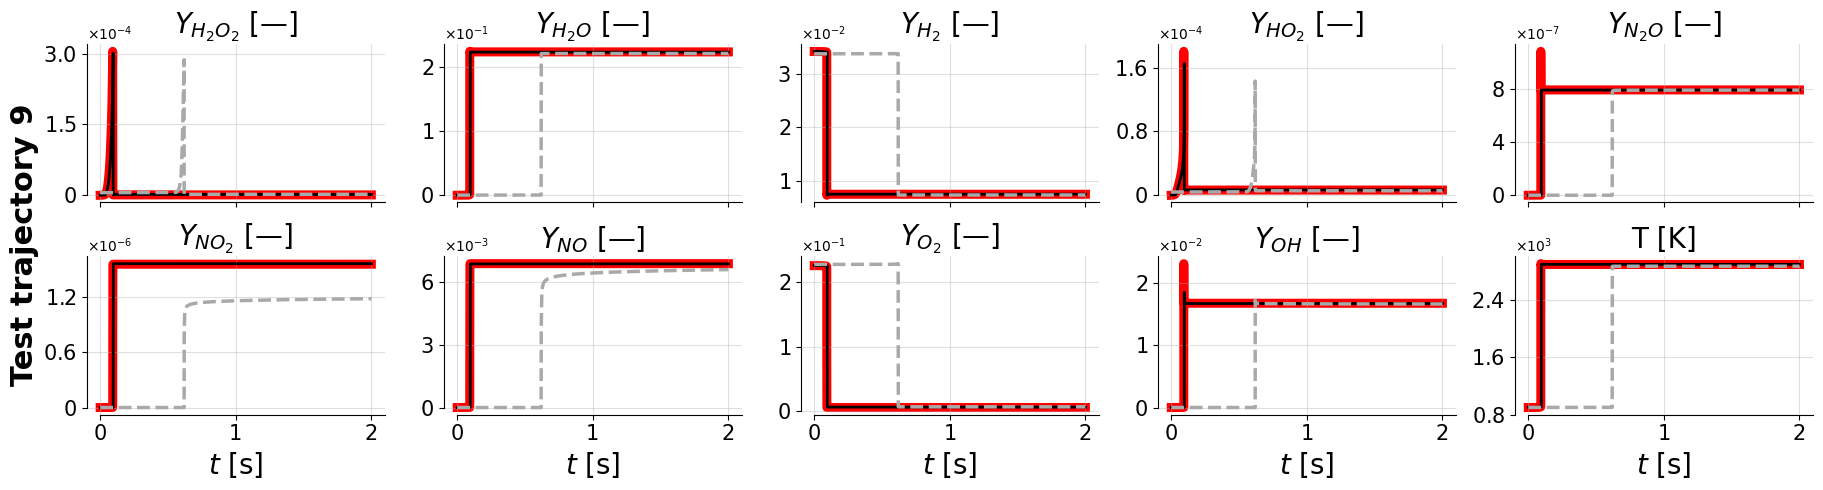

In [47]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Supplementary-material/A posteriori/"
name = f"Heuristic vs optimized {id_model} - A posteriori - ANN - timeExt"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

for idxSimulation in range(num_test_trajectories):

    rows, cols = 2, 5

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    axes = axes.flatten()

    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
    #test time trajectories
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
        test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])
    

    test_trajectory_time = test_trajectory_time.to_numpy().ravel()
    test_trajectory_time = torch.tensor(test_trajectory_time)
    deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

    last_value = test_trajectory_time[-1]
    new_times = []

    next_time = last_value + deltaTime
    while next_time <= 2:
        new_times.append(next_time.item())
        next_time += deltaTime

    
    for idxQoI in range(len(Output_species)): 
      ax = axes[idxQoI]

      #Add extension to the current tensor
      if new_times:
          extension = torch.tensor(new_times, dtype=torch.float32)
          test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

          last_value = test_trajectory[Output_species[idxQoI]].to_numpy()[-1]
          extension = np.tile(last_value, (len(new_times),))  #extension with last value of PV_optimized_test
          test_trajectory_QoI_ext = np.hstack((test_trajectory[Output_species[idxQoI]].to_numpy(), extension)) #concatenate the extension with the original value

      f_PV_Xu = list_simulations_Xu_ext[idxSimulation][:].detach().clone()

      if(scaledManifold_full_Xu):
              
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
            if(Xu_H2O == "H2O"):
                PV_Xu_test = test_trajectory["H2O"]
            elif(Xu_H2O == "Xu"):
                PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
            
            PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

        f_PV_Xu[:, 1] = (f_PV_Xu[:, 1] - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

      f_PV_opt = list_simulations_optimized_ext[idxSimulation][:].clone()

      if(scaledManifold_full_opt):
          with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
          state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
          PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
      
          f_PV_opt[:, 1] = (f_PV_opt[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

      prediction_Xu = (model_regression_full_Xu((f_PV_Xu-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5) + 1) /2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
      prediction_Xu = prediction_Xu.detach().numpy()

      prediction_optimized = (model_regression_full_optimized((f_PV_opt-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5) + 1) /2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
      prediction_optimized = prediction_optimized.detach().numpy()
      
      ax.plot(test_trajectory_time_ext, test_trajectory_QoI_ext, label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
      ax.plot(test_trajectory_time_ext, prediction_Xu[:, idxQoI], label = "ROM with the heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
      ax.plot(test_trajectory_time_ext, prediction_optimized[:, idxQoI], label = "ROM with the optimized PV", c="k", linestyle="-", linewidth=2, zorder = 2)
      
      if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
      else:
         ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


      ax.tick_params(axis='x', labelsize=15) 
      ax.tick_params(axis='y', labelsize=15)
      ax.set_xticks([0, 1, 2])
      ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
      if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
        
      else:
        ax.set_xticklabels([])
      
      #formatter = ScalarFormatter(useMathText=True)
      #formatter.set_powerlimits((0, 0))
      #ax.yaxis.set_major_formatter(formatter)
      
      class ZeroScalarFormatter(ScalarFormatter):
        def __call__(self, x, pos=None):
            if np.isclose(x, 0):
                return "0"
            return super().__call__(x, pos)

      formatter = ZeroScalarFormatter(useMathText=True)
      formatter.set_powerlimits((0, 0))

      ax.yaxis.set_major_formatter(formatter)
      
      ax.grid(True, linestyle='-', alpha=0.4)

      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)

      xmin, xmax = ax.get_xlim()
      ax.spines["bottom"].set_bounds(0, xmax)

      ymin, ymax = ax.get_ylim()
      if ymin < 0:
          ax.spines["left"].set_bounds(0, ymax)
          
    for j in range(len(Output_species), len(axes)): #disables axes of plots not used
      axes[j].axis("off")
    
    handles, labels = axes[0].get_legend_handles_labels()
    legend_handles = [
        Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
        Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the heuristic PV'),
        Line2D([0], [0], color='k', linestyle='dashdot', linewidth=5, label='ROM with the optimized PV'),
    ]
    if(idxSimulation == 0):
       
      fig.legend(legend_handles, labels,
                  loc='upper center', 
                  bbox_to_anchor=(0.5, 1.14), 
                  ncol=3, 
                  fontsize=23,
                  frameon=True
              )
    
    fig.text(-0.01, 0.5, f"Test trajectory {idxSimulation}", va='center', rotation='vertical', fontsize=22, fontweight='bold')

    plt.tight_layout()

    if(save):
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")

    if(i==0):
        plt.show()

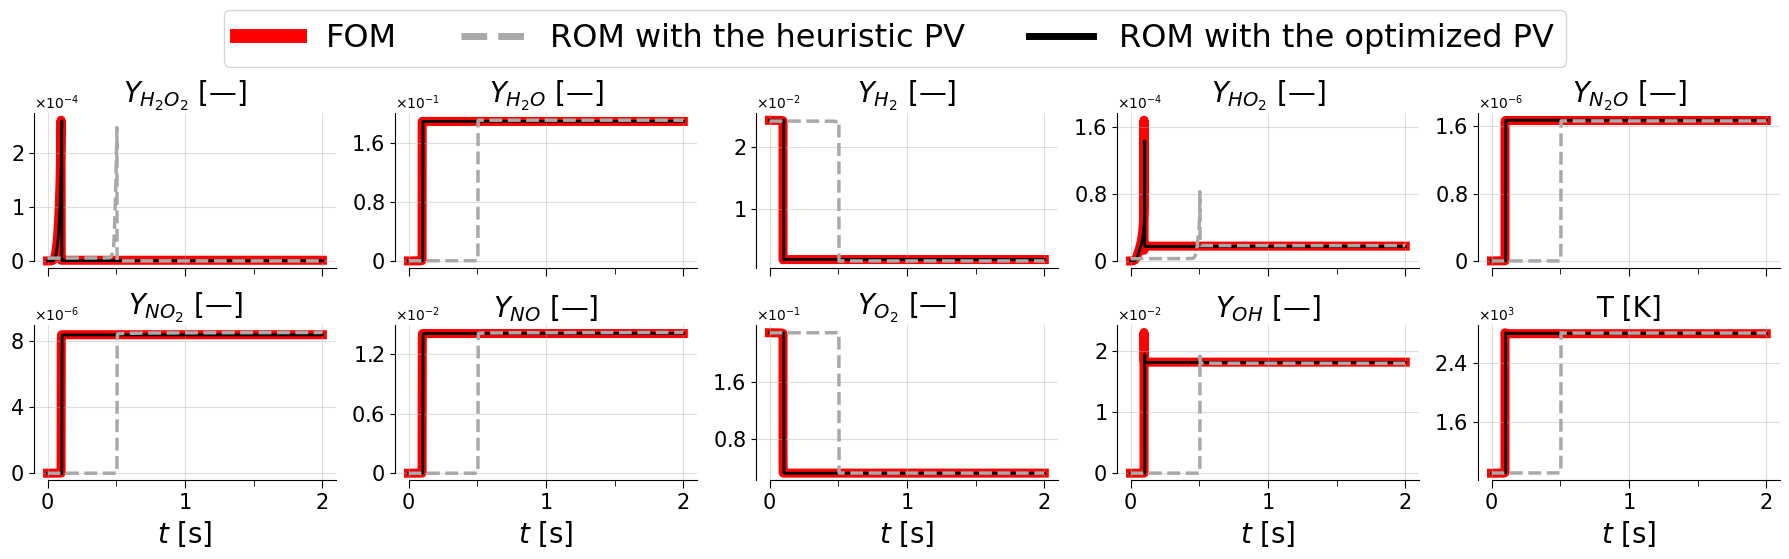

In [ ]:
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"
name = f"Figure 12 - A posteriori reconstructed - heuristic vs optimized 2s_s2.png"

Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

idxSimulation = 4

rows, cols = 2, 5

fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
axes = axes.flatten()

with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns = state_space_names)
#test time trajectories
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:])


test_trajectory_time = test_trajectory_time.to_numpy().ravel()
test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

last_value = test_trajectory_time[-1]
new_times = []

next_time = last_value + deltaTime
while next_time <= 2:
    new_times.append(next_time.item())
    next_time += deltaTime


for idxQoI in range(len(Output_species)): 
    ax = axes[idxQoI]

    #Add extension to the current tensor
    if new_times:
        extension = torch.tensor(new_times, dtype=torch.float32)
        test_trajectory_time_ext = torch.cat((test_trajectory_time, extension))

        last_value = test_trajectory[Output_species[idxQoI]].to_numpy()[-1]
        extension = np.tile(last_value, (len(new_times),))  #extension with last value of PV_optimized_test
        test_trajectory_QoI_ext = np.hstack((test_trajectory[Output_species[idxQoI]].to_numpy(), extension)) #concatenate the extension with the original value

    f_PV_Xu = list_simulations_Xu_ext[idxSimulation][:].clone()

    if(scaledManifold_full_Xu):
            
      if(Xu_H2O == "H2O"):
          PV_Xu_test = test_trajectory["H2O"]
      elif(Xu_H2O == "Xu"):
          PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
      
      PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

      f_PV_Xu[:, 1] = (f_PV_Xu[:, 1] - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    f_PV_opt = list_simulations_optimized_ext[idxSimulation][:].clone()

    if(scaledManifold_full_opt):
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_opt[:, 1] = (f_PV_opt[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    prediction_Xu = (model_regression_full_Xu((f_PV_Xu-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5) + 1) /2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
    prediction_Xu = prediction_Xu.detach().numpy()

    prediction_optimized = (model_regression_full_optimized((f_PV_opt-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5) + 1) /2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
    prediction_optimized = prediction_optimized.detach().numpy()
    
    ax.plot(test_trajectory_time_ext, test_trajectory_QoI_ext, label = "FOM", c="red", linestyle="-", linewidth=6.5, zorder = 1)  # True trajectory
    ax.plot(test_trajectory_time_ext, prediction_Xu[:, idxQoI], label = "ROM with the heuristic PV", c="darkgrey", linestyle="--", linewidth=2.5, zorder = 3)
    ax.plot(test_trajectory_time_ext, prediction_optimized[:, idxQoI], label = "ROM with the optimized PV", c="k", linestyle="-", linewidth=2, zorder = 2)
    
    if(Output_species[idxQoI] == "T"):
        ax.set_title(f"T [K]", fontsize = 20)
    else:
        ax.set_title(f"$Y_{{{Output_species_Latex[idxQoI]}}}$ [\u2014]", fontsize = 20)


    ax.tick_params(axis='x', labelsize=15) 
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xticks([0, 1, 2])

    # Minor ticks (unlabeled)
    ax.xaxis.set_minor_locator(FixedLocator([0.5, 1.5]))
    ax.xaxis.set_minor_formatter(NullFormatter())

    # Tick appearance
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4)

    # Grid: only major ticks
    ax.grid(True, which='major', axis='both', linestyle='-', alpha=0.4)
    ax.grid(False, which='minor', axis='x')
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter('%g')
    )
    if(idxQoI>= num_test_trajectories-cols):
        ax.set_xlabel(f"$t$ [s]", fontsize = 20)
    
    else:
        ax.set_xticklabels([])
    
    class ZeroScalarFormatter(ScalarFormatter):
        def __call__(self, x, pos=None):
            if np.isclose(x, 0):
                return "0"
            return super().__call__(x, pos)

    formatter = ZeroScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 0))

    ax.yaxis.set_major_formatter(formatter)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmin, xmax = ax.get_xlim()
    ax.spines["bottom"].set_bounds(0, xmax)

    ymin, ymax = ax.get_ylim()
    if ymin < 0:
        ax.spines["left"].set_bounds(0, ymax)
        

handles, labels = axes[0].get_legend_handles_labels()
legend_handles = [
    Line2D([0], [0], color='red', linestyle='-', linewidth=10, label='FOM'),
    Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM with the heuristic PV'),
    Line2D([0], [0], color='k', linestyle='-', linewidth=5, label='ROM with the optimized PV'),
]
    
fig.legend(legend_handles, labels,
            loc='upper center', 
            bbox_to_anchor=(0.5, 1.14), 
            ncol=3, 
            fontsize=23,
            frameon=True
        )

plt.tight_layout()

if(save):
    plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.png", dpi=1000, bbox_inches="tight")
    plt.savefig(f"{pathSave}{name}_testTraj{idxSimulation}.pdf", bbox_inches="tight")
if(i==0):
    plt.show()

C:\Windows\Temp\ipykernel_28904\1366334843.py:55: RuntimeWarning: divide by zero encountered in divide
  true_curve = (PV_Xu_test_ext-min_PV)/(max_PV-max_PV)
C:\Windows\Temp\ipykernel_28904\1366334843.py:55: RuntimeWarning: invalid value encountered in divide
  true_curve = (PV_Xu_test_ext-min_PV)/(max_PV-max_PV)


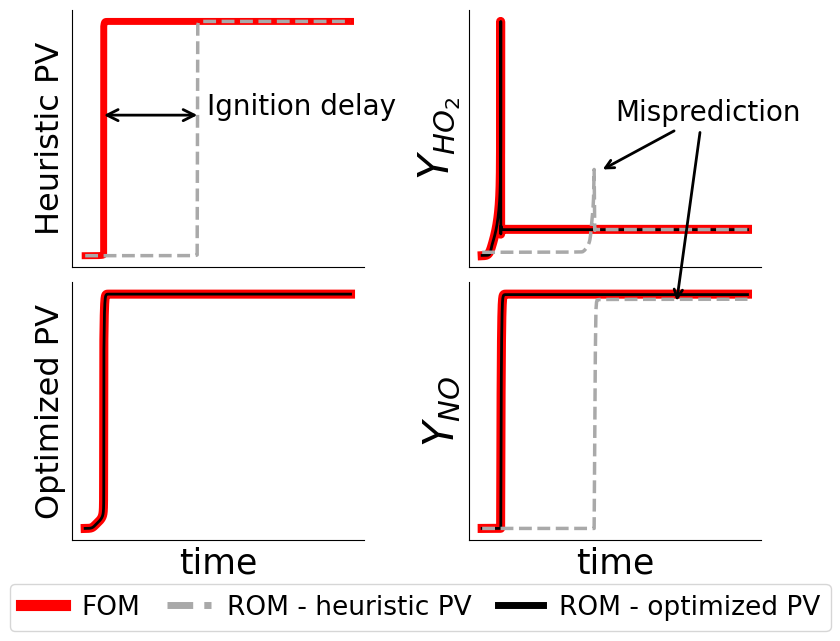

In [31]:
# --- Set parameters ---
save = True
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/Graphical-abstract/"
name = f"Heuristic vs optimized {id_model} - traj 1 - A posteriori - ANN - combined - graphical abstract with time"

i = 1
idxSimulation = 1
arrayHO2andNO = np.array([3, 6])  # Example indices
Output_species_Latex = [species.replace('2', '_2') for species in Output_species]

# --- Create 2x2 figure ---
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
(ax1, ax2), (ax3, ax4) = axes

# ================================================================
# TOP LEFT: Heuristic PV
# ================================================================
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)
    PV_Xu_test = (test_trajectory["H2O"] if Xu_H2O == "H2O" 
                  else test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"])
    PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1, 1)
    f_PV_Xu_test = np.hstack((np.full(PV_Xu_test.shape[0], mixture_fractions_test[i]).reshape(-1, 1), PV_Xu_test))

with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{i}'][:]).to_numpy().ravel()

test_trajectory_time = torch.tensor(test_trajectory_time)
deltaTime = test_trajectory_time[-1] - test_trajectory_time[-2]

# Extend time and PV
last_value = test_trajectory_time[-1]
new_times, next_time = [], last_value + deltaTime
while next_time <= 1.5:
    new_times.append(next_time.item())
    next_time += deltaTime



test_trajectory_time_ext = torch.cat((test_trajectory_time, torch.tensor(new_times, dtype=torch.float32)))
PV_Xu_test_ext = np.vstack((PV_Xu_test, np.tile(PV_Xu_test[-1], (len(new_times), 1))))

min_PV, max_PV = PV_Xu_test_ext.min(), PV_Xu_test_ext.max()

ax1.plot(test_trajectory_time_ext, (PV_Xu_test_ext-min_PV)/(max_PV-min_PV), 
         label="FOM", color="red", linestyle="-", linewidth=5)
ax1.plot(test_trajectory_time_ext, 
         (list_simulations_Xu_ext[i][:len(test_trajectory_time_ext),1].detach().numpy()-min_PV)/(max_PV-min_PV),
         label="ROM with a PV", color="darkgrey", linewidth=2.5, linestyle = "--")
ax1.set_ylabel('Heuristic PV', fontsize=23)
ax1.set_xticks([]); ax1.set_yticks([])
ax1.spines['top'].set_visible(False); ax1.spines['right'].set_visible(False)

# Add ignition delay arrow
true_curve = (PV_Xu_test_ext-min_PV)/(max_PV-max_PV)
true_times = test_trajectory_time_ext.numpy()
pred_curve = (list_simulations_Xu_ext[i][:,1].detach().numpy()-min_PV)/(max_PV-min_PV)
t_true = true_times[np.argmax(true_curve >= 0.99)]
t_pred = true_times[np.argmax(pred_curve >= 0.99)]
arrow = FancyArrowPatch((t_true+0.09, 0.6), (t_pred+0.01, 0.6),
                        arrowstyle="<->", color="black", linewidth=2,
                        mutation_scale=20, zorder = 5)
ax1.add_patch(arrow)
ax1.text(t_pred + 0.05, 0.6, "Ignition delay", fontsize=20)

# ================================================================
# BOTTOM LEFT: Optimized PV
# ================================================================
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)
    state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
    PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()

test_trajectory_time_ext = torch.cat((test_trajectory_time, torch.tensor(new_times, dtype=torch.float32)))
PV_optimized_test_ext = np.vstack((PV_optimized_test, np.tile(PV_optimized_test[-1], (len(new_times), 1))))
min_PV, max_PV = PV_optimized_test.min(), PV_optimized_test.max()

ax3.plot(test_trajectory_time_ext, (PV_optimized_test_ext-min_PV)/(max_PV-min_PV),
         label="FOM", color="red", linewidth=6.5)
ax3.plot(test_trajectory_time_ext,
         (list_simulations_optimized_ext[i].squeeze()[:len(test_trajectory_time_ext),1].detach().numpy()-min_PV)/(max_PV-min_PV),
         label="ROM with a PV", color="k", linewidth=2)
ax3.set_ylabel('Optimized PV', fontsize=23)
ax3.set_xticks([]); ax3.set_yticks([])
ax3.spines['top'].set_visible(False); ax3.spines['right'].set_visible(False)
ax3.set_xlabel("time", fontsize = 25)
ax4.set_xlabel("time", fontsize = 25)

# ================================================================
# RIGHT PLOTS: HO2 and NO
# ================================================================
with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
    test_trajectory = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:], columns=state_space_names)
with h5py.File(f"{path_data_autoignition}{filename_autoignition}time-test-trajectories.h5", 'r') as hf:
    test_trajectory_time = pd.DataFrame(hf[f'test_trajectory_{idxSimulation}'][:]).to_numpy().ravel()
test_trajectory_time_ext = torch.cat((torch.tensor(test_trajectory_time),
                                      torch.tensor(new_times, dtype=torch.float32)))

for idxAx, idxQoI, ax in zip(range(2), arrayHO2andNO, [ax2, ax4]):
    test_trajectory_QoI_ext = np.hstack((
        test_trajectory[Output_species[idxQoI]].to_numpy(),
        np.tile(test_trajectory[Output_species[idxQoI]].to_numpy()[-1], len(new_times))
    ))

    f_PV_Xu = list_simulations_Xu_ext[idxSimulation][:].clone()

    if(scaledManifold_full_Xu):
            
      if(Xu_H2O == "H2O"):
          PV_Xu_test = test_trajectory["H2O"]
      elif(Xu_H2O == "Xu"):
          PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
      
      PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

      f_PV_Xu[:, 1] = (f_PV_Xu[:, 1] - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    f_PV_opt = list_simulations_optimized_ext[idxSimulation][:].clone()

    if(scaledManifold_full_opt):
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_opt[:, 1] = (f_PV_opt[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())

    pred_Xu = (model_regression_full_Xu((f_PV_Xu-mins_input_full_Xu)/
                                        (maxs_input_full_Xu-mins_input_full_Xu)-0.5)+1)/2*(
              maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
    pred_optimized = (model_regression_full_optimized((f_PV_opt-mins_input_full_optimized)/
                                                      (maxs_input_full_optimized-mins_input_full_optimized)-0.5)+1)/2*(
              maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
    pred_Xu = pred_Xu.detach().numpy()
    pred_optimized = pred_optimized.detach().numpy()

    ax.plot(test_trajectory_time_ext, test_trajectory_QoI_ext, label="FOM", c="red", linewidth=6.5)
    ax.plot(test_trajectory_time_ext, pred_Xu[:len(test_trajectory_time_ext), idxQoI], label="ROM - heuristic PV", c="darkgrey", linestyle="--", linewidth = 2.5, zorder = 3)
    ax.plot(test_trajectory_time_ext, pred_optimized[:len(test_trajectory_time_ext), idxQoI], label="ROM - optimized PV", c="k", linewidth = 2)
    ax.set_ylabel(f"$Y_{{{Output_species_Latex[idxQoI]}}}$", fontsize=30)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)


ax2.annotate(
    "Misprediction",
    xy=(0.45, 0.375), xycoords='axes fraction',  # arrow tip  #arrow4: (0.24, 0.45)
    xytext=(0.5, 0.6), textcoords='axes fraction',  # text position   #arrow 4: (0.4, 0.45)
    arrowprops=dict(
        arrowstyle="->",
        color="black",
        linewidth=2,
        mutation_scale=15
    ),
    fontsize=20,
    ha="left",
    va="center"
)

fig = plt.gcf()

# Coordinates in figure fraction: (0,0) bottom-left of the whole figure, (1,1) top-right
# You'll need to tune these numbers by trial to align with the subplot positions
arrow = FancyArrowPatch(
    (0.85, 0.775),   # start point (e.g., misprediction on ax3)  #arrow 4: (0.8, 0.7)
    (0.82, 0.485),   # end point (e.g., target inside ax4)       #arrow 4: (0.8, 0.5)
    transform=fig.transFigure,
    arrowstyle="->",
    color="black",
    linewidth=2,
    mutation_scale=15,
    connectionstyle="arc3,rad=0.0"  # straight line, adjust rad for curved
)

fig.patches.append(arrow)

# Legend
legend_handles = [
    Line2D([0], [0], color='red', linewidth=8, label='FOM'),
    Line2D([0], [0], color='darkgrey', linestyle='--', linewidth=5, label='ROM - heuristic PV'),
    Line2D([0], [0], color='k', linewidth=5, label='ROM - optimized PV'),
]
fig.legend(legend_handles, [h.get_label() for h in legend_handles],
           loc='upper center', bbox_to_anchor=(0.5, 0.04), ncol=3, fontsize=19,
            handlelength=1.7, handletextpad=0.6, columnspacing=1)

plt.tight_layout()

if save:
    plt.savefig(f"{pathSave}{name}.png", dpi=1000, bbox_inches="tight")
    plt.savefig(f"{pathSave}{name}.pdf", bbox_inches="tight")
plt.show()


### Min, median and max error of relative error of max and SS

In [32]:
from collections import defaultdict
import numpy as np

# Store errors per species
errors_max_heuristic = defaultdict(list)
errors_last_heuristic = defaultdict(list)
errors_max_optimized = defaultdict(list)
errors_last_optimized = defaultdict(list)

for i in range(10):

    f_PV_Xu = list_simulations_Xu_ext[i][:].detach().clone()

    if(scaledManifold_full_Xu):
            
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
            if(Xu_H2O == "H2O"):
                PV_Xu_test = test_trajectory["H2O"]
            elif(Xu_H2O == "Xu"):
                PV_Xu_test = test_trajectory["H2O"] - test_trajectory["H2"] - test_trajectory["O2"]
        
        PV_Xu_test = PV_Xu_test.to_numpy().reshape(-1,1)

    f_PV_Xu[:, 1] = (f_PV_Xu[:, 1] - PV_Xu_test.min())/(PV_Xu_test.max() - PV_Xu_test.min())

    f_PV_opt = list_simulations_optimized_ext[i][:].clone()

    if(scaledManifold_full_opt):
        with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
            test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns = state_space_names)
        state_space_test_DNS = test_trajectory[state_space_names_DNS].to_numpy()
        PV_optimized_test = PV_model.get_PV(torch.from_numpy(np.delete(state_space_test_DNS, idx_species_removed, axis=1))).detach().numpy()
    
        f_PV_opt[:, 1] = (f_PV_opt[:, 1] - PV_optimized_test.min())/(PV_optimized_test.max() - PV_optimized_test.min())


    # --- Predictions ---
    prediction_Xu = (model_regression_full_Xu(
        (f_PV_Xu-mins_input_full_Xu)/(maxs_input_full_Xu-mins_input_full_Xu) - 0.5
    ) + 1) / 2 * (maxs_output_full_Xu - mins_output_full_Xu) + mins_output_full_Xu
    prediction_Xu = prediction_Xu.detach().numpy()

    prediction_optimized = (model_regression_full_optimized(
        (f_PV_opt-mins_input_full_optimized)/(maxs_input_full_optimized-mins_input_full_optimized) - 0.5
    ) + 1) / 2 * (maxs_output_full_optimized - mins_output_full_optimized) + mins_output_full_optimized
    prediction_optimized = prediction_optimized.detach().numpy()

    # --- Ground truth trajectory ---
    with h5py.File(f"{path_data_autoignition}{filename_autoignition}state-space-test-trajectories.h5", 'r') as hf:
        test_trajectory = pd.DataFrame(hf[f'test_trajectory_{i}'][:], columns=state_space_names)

    for j, species in enumerate(Output_species):
        trueValues = test_trajectory[species].to_numpy()

        max_true = np.max(trueValues)
        last_true = trueValues[-1]

        max_pred_heuristic = np.max(prediction_Xu[:, j])
        last_pred_heuristic = prediction_Xu[-1, j]

        max_pred_optimized = np.max(prediction_optimized[:, j])
        last_pred_optimized = prediction_optimized[-1, j]

        # --- Relative errors (normalize by |max_true|) ---
        if max_true != 0:
            err_max_h = abs(max_true - max_pred_heuristic) / abs(max_true)
            err_last_h = abs(last_true - last_pred_heuristic) / abs(max_true)

            err_max_o = abs(max_true - max_pred_optimized) / abs(max_true)
            err_last_o = abs(last_true - last_pred_optimized) / abs(max_true)

            errors_max_heuristic[species].append(err_max_h)
            errors_last_heuristic[species].append(err_last_h)
            errors_max_optimized[species].append(err_max_o)
            errors_last_optimized[species].append(err_last_o)

# --- Aggregate results ---
results = {}
for species in Output_species:
    results[species] = {
        "heuristic": {
            "max_error": {
                "min": float(np.min(errors_max_heuristic[species])),
                "median": float(np.median(errors_max_heuristic[species])),
                "max": float(np.max(errors_max_heuristic[species]))
            },
            "last_error": {
                "min": float(np.min(errors_last_heuristic[species])),
                "median": float(np.median(errors_last_heuristic[species])),
                "max": float(np.max(errors_last_heuristic[species]))
            },
        },
        "optimized": {
            "max_error": {
                "min": float(np.min(errors_max_optimized[species])),
                "median": float(np.median(errors_max_optimized[species])),
                "max": float(np.max(errors_max_optimized[species]))
            },
            "last_error": {
                "min": float(np.min(errors_last_optimized[species])),
                "median": float(np.median(errors_last_optimized[species])),
                "max": float(np.max(errors_last_optimized[species]))
            },
        }
    }

# Print nicely
import pprint
pprint.pprint(results, width=120)

{'H2': {'heuristic': {'last_error': {'max': 0.012762488364022386,
                                     'median': 0.0051534624309157815,
                                     'min': 0.0006987610288083569},
                      'max_error': {'max': 0.012555524847831175,
                                    'median': 0.005695080141447995,
                                    'min': 0.0013225120966836358}},
        'optimized': {'last_error': {'max': 0.00282000797608993,
                                     'median': 0.0009013579298955919,
                                     'min': 0.000373979510220512},
                      'max_error': {'max': 0.0026075075795596197,
                                    'median': 0.000679941785583076,
                                    'min': 0.00026303659184325764}}},
 'H2O': {'heuristic': {'last_error': {'max': 0.011008628926054715,
                                      'median': 0.0038906951226291096,
                                      'min': 3.7674

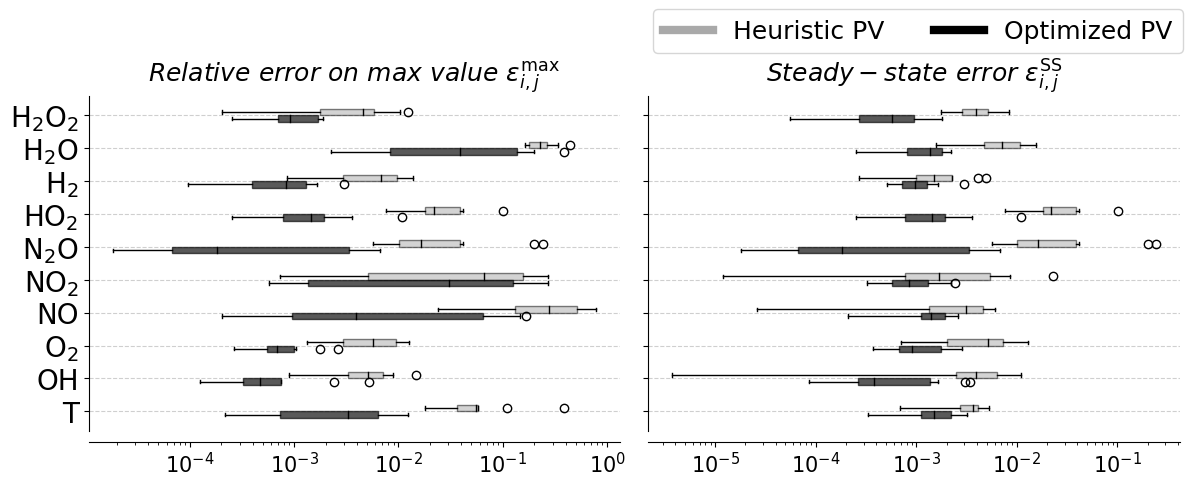

In [ ]:
save = True
name = "Figure 13 - Boxplots max and SS error - ANN a posteriori 0D - new models.png"
namePdf = "Figure 13 - Boxplots max and SS error - ANN a posteriori 0D - new models.pdf"
pathSave = "C:/Users/admin/Documents/PhD-ULB/Figures/2024-PV-optimization/Paper/EnergyAndAI/"

# --- Prepare data ---
qois = list(results.keys())
n_qoi = len(qois)

# Collect errors in the order of QoIs
SS_heu = [errors_last_heuristic[qoi] for qoi in qois]
SS_opt = [errors_last_optimized[qoi] for qoi in qois]
max_heu   = [errors_max_heuristic[qoi] for qoi in qois]
max_opt   = [errors_max_optimized[qoi] for qoi in qois]

# Positions for horizontal boxplots
y_pos = np.arange(n_qoi)
width = 0.2  # distance between boxes

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=True)

# --- Left subplot: Last error ---
for i in range(n_qoi):
    axes[0].boxplot(max_heu[i], positions=[y_pos[i] + width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='darkgrey', alpha=0.5),
                    medianprops=dict(color='black'))
    axes[0].boxplot(max_opt[i], positions=[y_pos[i] - width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='black', alpha=0.65),
                    medianprops=dict(color='black'))

axes[0].set_yticks(y_pos)
axes[0].set_yticklabels(qois)
axes[0].set_title(r"$\mathit{Relative\ error\ on\ max\ value}\ \varepsilon^{\max}_{i,j}$", fontsize = 18)
axes[0].set_xscale("log")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

# --- Right subplot: Steady-state error ---
for i in range(n_qoi):
    axes[1].boxplot(SS_heu[i], positions=[y_pos[i] + width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='darkgrey', alpha=0.5),
                    medianprops=dict(color='black'))
    axes[1].boxplot(SS_opt[i], positions=[y_pos[i] - width/2], vert=False, widths=width, patch_artist=True,
                    boxprops=dict(facecolor='black', alpha=0.65),
                    medianprops=dict(color='black'))

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([q.replace("2", "$_2$") for q in qois[::-1]])
axes[1].set_title(r"$\mathit{Steady-state\ error}\ \varepsilon^{\mathrm{SS}}_{i,j}$", fontsize = 18)
axes[1].set_xscale("log")
axes[0].tick_params(axis='both', labelsize=20)  # y-tick labels
axes[0].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

for i in range(len(axes)):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

offset = 8

axes[0].spines['bottom'].set_position(('outward', offset))
axes[1].spines['bottom'].set_position(('outward', offset))

# --- Legend ---
handles = [
    mlines.Line2D([0], [0], color='darkgrey', lw=6),
    mlines.Line2D([0], [0], color='black', lw=6)
]

labels = ['Heuristic PV', 'Optimized PV']

# Add legend to the figure (not tied to any subplot)
fig.legend(handles, labels, bbox_to_anchor=(1, 1.1), ncol=2, fontsize=18)

plt.tight_layout()
if save:
    plt.savefig(pathSave + name, bbox_inches = "tight", dpi = 300)
    plt.savefig(pathSave + namePdf, bbox_inches = "tight")
plt.show()